# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import pickle
import time
import pprint
import random

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';' , dtype={18:'str',19:'str'})
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';' , dtype={18:'str',19:'str'})

In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
print(azdias.shape)
print(customers.shape)

(891221, 366)
(191652, 369)


The feature summary file from the previous project contains a summary of properties for each demographics data column. The additional columns found in this project will be assessed manually to complete the rest of the properties. The file DIAS Attributes - Values 2017.xlsx will be studied for this assessment. This will help make cleaning decisions during this stage of the project.

In [4]:
# Load feature summary csv file
feat_info = pd.read_csv('feature_complete.csv')
feat_info.set_index('attribute', inplace=True)
feat_info.head()



,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


In [5]:
# Data shape
azdias.shape


(891221, 366)

In [6]:
# Data info
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [7]:
# Shape of feat_info
feat_info.shape

(324, 3)

In [8]:

#Lets check the no. of attributes that are present in azdias but not in feat_info
attr_not_in_feat_info = np.setdiff1d(np.array(azdias.columns), np.array(feat_info.index), assume_unique=True)
print(len(attr_not_in_feat_info))

53


So, there are 53 attributes in azdias dataframe that not in feat_info dataframe 

In [9]:

#Check the no of common attribute in azdias and feat_info
common_attr = set(azdias.columns.tolist()).intersection(set(feat_info.index.tolist()))
print(len(common_attr))

313



So, there are 313 attributes common to both azdias & feat_info dataframe .

In [10]:

# No. of attributes present in feat_info but not in azdias
attr_not_in_azdias = set(feat_info.index.tolist()) - common_attr
print(len(attr_not_in_azdias))

11


In [11]:
# Extra columns in customers df
extra_col_cust = set(customers.columns.tolist()) - set(azdias.columns.tolist())
print(extra_col_cust)
customers[list(extra_col_cust)].head()

{'CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'}


,CUSTOMER_GROUP,PRODUCT_GROUP,ONLINE_PURCHASE
0,MULTI_BUYER,COSMETIC_AND_FOOD,0
1,SINGLE_BUYER,FOOD,0
2,MULTI_BUYER,COSMETIC_AND_FOOD,0
3,MULTI_BUYER,COSMETIC,0
4,MULTI_BUYER,FOOD,0


We can remove those extra columns from our analysis

In [12]:
# Remove extra 3 columns in customers df
customers.drop(list(extra_col_cust), axis=1, inplace=True)

# Shape of customers df after removal 
customers.shape

(191652, 366)

Now, from above, both azdias df & customer df have same and equal number of columns.

In [13]:
null_list = azdias.isnull().sum()
null_per = null_list / len(azdias) * 100

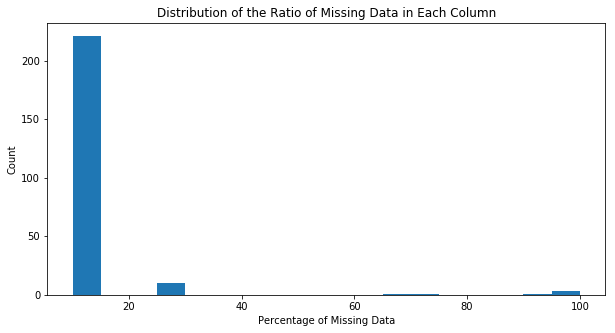

In [14]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(10,5))
plt.title('Distribution of the Ratio of Missing Data in Each Column')
plt.hist(null_per, bins = np.linspace(10,100,19))
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Count')
plt.show()

Here i can consider that columns with 20% missing value can be dropped. Thats why we dropped {'CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'} columns.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

# Step 1: Preprocessing

Assess Missing Data
The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the Discussion cell with your findings and decisions at the end of each step that has one!


Step 1.1.1: Convert Missing Value Codes to NaNs
The third column of the feature attributes summary (loaded in above as feat_info) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. [-1,0]), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [15]:
#Identify missing or unknown data values and convert them to NaNs

# Check natural NaNs
azdias.isnull().sum()

LNR                                0
AGER_TYP                           0
AKT_DAT_KL                     73499
ALTER_HH                       73499
ALTER_KIND1                   810163
ALTER_KIND2                   861722
ALTER_KIND3                   885051
ALTER_KIND4                   890016
ALTERSKATEGORIE_FEIN          262947
ANZ_HAUSHALTE_AKTIV            93148
ANZ_HH_TITEL                   97008
ANZ_KINDER                     73499
ANZ_PERSONEN                   73499
ANZ_STATISTISCHE_HAUSHALTE     93148
ANZ_TITEL                      73499
ARBEIT                         97216
BALLRAUM                       93740
CAMEO_DEU_2015                 98979
CAMEO_DEUG_2015                98979
CAMEO_INTL_2015                98979
CJT_GESAMTTYP                   4854
CJT_KATALOGNUTZER               4854
CJT_TYP_1                       4854
CJT_TYP_2                       4854
CJT_TYP_3                       4854
CJT_TYP_4                       4854
CJT_TYP_5                       4854
C

In [16]:
# Define function to find missing values in the features
def find_missing_data(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing values in its columns
    OUTPUT:
        df_null: (dataframe), with count & percentage of missing values in input dataframe columns
    '''
    null_data = df.isnull().sum()[df.isnull().sum() > 0]
    
    data_dict = {'count': null_data.values, 'pct': np.round(null_data.values *100/df.shape[0],2)}
    
    df_null = pd.DataFrame(data=data_dict, index=null_data.index)
    df_null.sort_values(by='count', ascending=False, inplace=True)
    return df_null

In [17]:
%%time
# Naturally missing data in descenindg order
azdias_null = find_missing_data(azdias)
azdias_null

CPU times: user 13.5 s, sys: 3.36 s, total: 16.8 s
Wall time: 2min 14s


In [18]:
azdias_null

,count,pct
ALTER_KIND4,890016,99.86
ALTER_KIND3,885051,99.31
ALTER_KIND2,861722,96.69
ALTER_KIND1,810163,90.90
EXTSEL992,654153,73.40
KK_KUNDENTYP,584612,65.60
ALTERSKATEGORIE_FEIN,262947,29.50
D19_SOZIALES,257113,28.85
D19_LOTTO,257113,28.85
D19_BANKEN_ONLINE_QUOTE_12,257113,28.85


In [19]:
# Shape of azdias_init_null dataframe
azdias_null.shape

(273, 2)

In [20]:
# Total number of naturally missing values
np.sum(azdias_null['count'])

33492923

So, 273 columns have naturally missing data which is not encoded by the codes as mentioned in feature_summary_complete.csv file. We can see that even before mapping missing_or_unknown values to NaN, columns KK_KUNDENTYP, EXTSEL992, ALTER_KIND1, ALTER_KIND2, ALTER_KIND3 & ALTER_KIND4 has more than 65% of missing values.

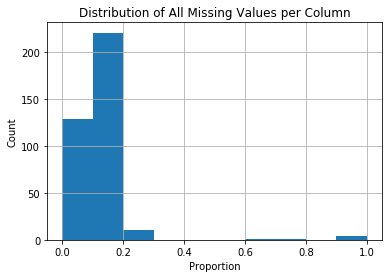

In [21]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_col = azdias.isnull().sum()/azdias.shape[0]

missing_col.hist()
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');

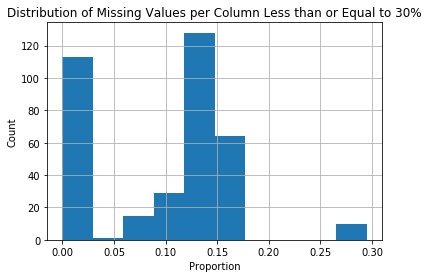

In [22]:
# Investigate patterns in the amount of missing data in each column.
missing_col_sub = missing_col[missing_col <= 0.3]

missing_col_sub.hist()
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of Missing Values per Column Less than or Equal to 30%');

In [23]:
# Printing out a column missing_or_unknown value and its type for a particular attribute.
print(feat_info.loc[['AGER_TYP'], ['missing_or_unknown']].missing_or_unknown.item())
print('Type of missing_or_unknown column value : {}'.format(type(feat_info.\
                                                                 loc[['AGER_TYP'], ['missing_or_unknown']].\
                                                                 missing_or_unknown.item())))


# Parsing missing_or_unknown column having string values to array of lists and storing it in new columnn nan_vals.
nan_vals = feat_info['missing_or_unknown'].str.replace('[','').str.replace(']','').str.split(',').values

# Adding nan_vals column to the dataframe.
feat_info['nan_vals'] = nan_vals
#print(type(feat_info))

# Printing out the value and type of value in nan_vals column for a particular attribute after parsing.
print(feat_info.loc[['AGER_TYP'], ['nan_vals']].nan_vals.item())
print('Type of nan_vals column value : {}'.format(type(feat_info.loc[['AGER_TYP'], ['nan_vals']].nan_vals.item())))

[-1,0]
Type of missing_or_unknown column value : <class 'str'>
['-1', '0']
Type of nan_vals column value : <class 'list'>


In [24]:

feat_info.head()

,information_level,type,missing_or_unknown,nan_vals
attribute,,,,
AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
CJT_GESAMTTYP,person,categorical,[0],[0]
FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [25]:
# Converting (list of string) values to (list of integers and string) in nan_vals column.

def is_int(value):
    try:
        int(value)

        return True
    except ValueError:
       
        return False

feat_info['nan_vals'] = feat_info.apply(lambda x: [int(i) if is_int(i) else i for i in x['nan_vals']], axis=1)

In [26]:
# Printing out the value and type of value in nan_vals column for a particular attribute after converting
# to list of integers and string

print(feat_info.loc[['AGER_TYP'], ['nan_vals']].nan_vals.item())
print('Type of nan_vals column value : {}'.format(type(feat_info.loc[['AGER_TYP'], ['nan_vals']].nan_vals.item())))

[-1, 0]
Type of nan_vals column value : <class 'list'>


In [27]:
# Identify missing or unknown data values in azdias dataframe columns and convert them to NaNs as per nan_vals in feat_info
for inx in feat_info.index:
    column = inx
    if column in azdias.columns:
        azdias[column] = azdias[column].replace(feat_info.loc[column]['nan_vals'], np.nan)

In [28]:
# Check after mapping missing_or_unknown values.
azdias['CAMEO_DEUG_2015'][2511]

nan


Step 1.1.2: Assess Missing Data in Each Column
How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's hist() function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [29]:
# Perform an assessment of how much missing data there is in each column of the azdias dataset 
# Count value of NaN values in each column in descending order.
azdias_after_nan = find_missing_data(azdias)
azdias_after_nan

,count,pct
ALTER_KIND4,890016,99.86
TITEL_KZ,889061,99.76
ALTER_KIND3,885051,99.31
ALTER_KIND2,861722,96.69
ALTER_KIND1,810163,90.90
AGER_TYP,685843,76.96
EXTSEL992,654153,73.40
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,476524,53.47
GEBURTSJAHR,392318,44.02


So, 281 columns have NaN data and we can see that after mapping missing_or_unknown values to NaN, columns TITEL_KZ, ALTER_KIND1, ALTER_KIND2, ALTER_KIND3 & ALTER_KIND4 has more than 65% of missing values.

In [30]:
# Total number of missing obersvations after mapping missing_or_unknown values to NaN
# by using codes mentioned in feature summary file.
np.sum(azdias_after_nan['count'])

37827227

In [31]:
# Investigating patterns in the amount of missing data of each column.
index_column_info = {}
for info in feat_info['information_level'].unique():
    index_column_info[info] = feat_info[feat_info['information_level'] == info].index.values
    
index_column_info

{'person': array(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
        'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
        'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
        'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
        'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
        'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
        'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
        'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
        'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
        'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
        'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ',
        'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP'], dtype=object),
 'household': array(['ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HAUSHALTSSTRUKTUR',
        'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'D19_KONSUMTYP',
        'D19_GESAMT_ANZ_12

In [32]:

index_column_info.keys()

dict_keys(['person', 'household', 'building', 'microcell_rr4', 'microcell_rr3', '125m_125m_grid', 'postcode', 'region_rr1', 'plz8', 'community'])

In [33]:
index_column_info['person']

array(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ',
       'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP'], dtype=object)

In [36]:
# Define function to find columns with 20% missing values
def cols_missing_values(df, p):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing values in its columns
    OUTPUT:
        missing_cols: (list), list of columns 
    '''
    missing_cols = [col for col in df.columns if (df[col].isnull().sum()/df.shape[0]) * 100 > p]
    return missing_cols

In [37]:
# Find the name of columns with more than 20% missing values
missing_20_prcnt_cols = cols_missing_values(azdias, p=20)
print(missing_20_prcnt_cols)

['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


In [38]:
# Remove the outlier columns from the dataset.
azdias.drop(missing_20_prcnt_cols, axis=1, inplace=True)

In [39]:
azdias.drop('LNR', axis=1, inplace=True)

In [40]:

# Shape of azdias dataframe after removing outliers columns
azdias.shape

(891221, 344)

Assess Missing Data in Each Row
Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.

You can use seaborn's countplot() function to create a bar chart of code frequencies and matplotlib's subplot() function to put bar charts for the two subplots side by side.
To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.
Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.

In [41]:
# How much data is missing in each row of the dataset?
azdias_missing_data_row = azdias.isnull().sum(axis=1)

# Aggregate missing row data by number of missing values per row
print('Below are the number of missing values in a row along with their frequencies')
azdias_missing_data_row.value_counts().sort_index()

Below are the number of missing values in a row along with their frequencies


0      611722
1       10335
2       26076
3       17884
4       12937
5        4252
6       24953
7        9923
8       11004
9         872
10       1254
11        667
12        479
13        262
14        151
15         74
16         26
17         17
18          7
19          4
20       1916
21         23
22         84
23       1901
24         97
25        106
26         87
27         73
28         46
29         45
        ...  
210         2
211         1
212         6
213         4
214         3
215         6
216         2
217         2
218       206
219      2870
220     10880
221      3960
222        82
223        84
224       730
225       223
226       138
227       344
228        12
229        13
230        10
238     27348
239       111
240       508
241         8
242         6
243     45606
244         9
245         2
247         1
Length: 174, dtype: int64

In [42]:
# Aggregate missing row data by percentage of missing values per row
tt = azdias_missing_data_row/(len(azdias.columns)) * 100
tt.sort_values(inplace=True)
tt.value_counts().sort_index()

0.000000     611722
0.290698      10335
0.581395      26076
0.872093      17884
1.162791      12937
1.453488       4252
1.744186      24953
2.034884       9923
2.325581      11004
2.616279        872
2.906977       1254
3.197674        667
3.488372        479
3.779070        262
4.069767        151
4.360465         74
4.651163         26
4.941860         17
5.232558          7
5.523256          4
5.813953       1916
6.104651         23
6.395349         84
6.686047       1901
6.976744         97
7.267442        106
7.558140         87
7.848837         73
8.139535         46
8.430233         45
              ...  
61.046512         2
61.337209         1
61.627907         6
61.918605         4
62.209302         3
62.500000         6
62.790698         2
63.081395         2
63.372093       206
63.662791      2870
63.953488     10880
64.244186      3960
64.534884        82
64.825581        84
65.116279       730
65.406977       223
65.697674       138
65.988372       344
66.279070        12


In [44]:
# Calculate count and percentage of rows with no missing data points

print('No. of rows with no missing data: {}'\
      .format(np.round(azdias_missing_data_row.value_counts().sort_index().cumsum()[0])))
print('Total no.of rows in dataset: {}'.format(azdias.shape[0]))
print('Percentage of rows with no missing data : {}%'\
      .format(azdias_missing_data_row.value_counts().sort_index().cumsum()[0]/azdias.shape[0] *100,2))

No. of rows with no missing data: 611722
Total no.of rows in dataset: 891221
Percentage of rows with no missing data : 68.63864294041545%


In [48]:
# Calculate cumulative sum of rows with 28 or less missing data points
cumsum= azdias_missing_data_row.value_counts().sort_index().cumsum()[:28]
print('Cumulative sums of rows with 28 or less missing data points are : \n{}'.format(cumsum))

cumsum_percentage = np.round(azdias_missing_data_row.value_counts().sort_index().cumsum()[:28]/azdias_missing_data_row.shape[0]*100,2)
print('\nCumulative percentage of rows with 28 or less missing data points are : \n{}'.format(cumsum_percentage))

Cumulative sums of rows with 28 or less missing data points are : 
0     611722
1     622057
2     648133
3     666017
4     678954
5     683206
6     708159
7     718082
8     729086
9     729958
10    731212
11    731879
12    732358
13    732620
14    732771
15    732845
16    732871
17    732888
18    732895
19    732899
20    734815
21    734838
22    734922
23    736823
24    736920
25    737026
26    737113
27    737186
dtype: int64

Cumulative percentage of rows with 28 or less missing data points are : 
0     68.64
1     69.80
2     72.72
3     74.73
4     76.18
5     76.66
6     79.46
7     80.57
8     81.81
9     81.91
10    82.05
11    82.12
12    82.17
13    82.20
14    82.22
15    82.23
16    82.23
17    82.23
18    82.23
19    82.24
20    82.45
21    82.45
22    82.46
23    82.68
24    82.69
25    82.70
26    82.71
27    82.72
dtype: float64


In [49]:

# Calculate percentage of rows with 8 or less missing data points

print('Count of rows with 8 or less missing data points: {}'.format(cumsum[8]))
print('Total number of rows in the dataset : {}'.format(azdias.shape[0]))
print("Percentage of rows with 8 or less missing data points:",cumsum_percentage[8],"%")

Count of rows with 8 or less missing data points: 729086
Total number of rows in the dataset : 891221
Percentage of rows with 8 or less missing data points: 81.81 %


In [59]:


# Write code to divide the data into two subsets based on the number of missing
# values to be 8 or less in each row.

#azdias_null_data_row_few = azdias[azdias.isnull().sum(axis=1) < 9].reset_index(drop=True)
azdias_null_data_row_few = azdias[azdias.isnull().sum(axis=1) < 9]

#azdias_null_data_row_high = azdias[azdias.isnull().sum(axis=1) >= 9].reset_index(drop=True)
azdias_null_data_row_high = azdias[azdias.isnull().sum(axis=1) >= 9]

In [60]:
# Printing the number of rows with few missing data and high missing data.
print('Number of rows with few missing data : {}'.format(azdias_null_data_row_few.shape[0]))
print('Number of rows with high missing data : {}'.format(azdias_null_data_row_high.shape[0]))

# Checking if the number of rows with few missing data and high missing data adds upto total number of rows in azdias dataset.
if azdias.shape[0] == azdias_null_data_row_few.shape[0] + azdias_null_data_row_high.shape[0]:
    print('Number of rows with few missing data and high missing data adds upto total number of rows in azdias dataset,\
 which is : {}'.format(azdias_null_data_row_few.shape[0] + azdias_null_data_row_high.shape[0]))
else:
    print('Number of total rows in few missing dataset and high missing dataset is not equal\
    to the total number of rows in the dataset')
    

Number of rows with few missing data : 729086
Number of rows with high missing data : 0
Number of rows with few missing data and high missing data adds upto total number of rows in azdias dataset, which is : 729086


In [73]:
# Printing columns with no or less than 2 missing values in columns of azdias dataset with outliers columns removed.

azdias_no_null_columns = azdias.isnull().sum() < 2 
print('Below are the columns of azdias dataset with no nulls or less than 2 missing values\n')
print(azdias_no_null_columns[azdias_no_null_columns.values == True].index)

Below are the columns of azdias dataset with no nulls or less than 2 missing values

Index(['AKT_DAT_KL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'CJT_GESAMTTYP',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3',
       ...
       'SOHO_KZ', 'UNGLEICHENN_FLAG', 'VHA', 'VK_DHT4A', 'VK_DISTANZ',
       'VK_ZG11', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ'],
      dtype='object', length=299)


In [76]:

print('Total number of rows : {}'.format(azdias.shape[0]))

azdias = azdias[azdias.index.isin(azdias_missing_data_row_less.index)]

print('Number of rows after dropping rows with more than 8 missing values : {}'.format(azdias.shape[0]))

Total number of rows : 729086
Number of rows after dropping rows with more than 8 missing values : 729086


 Assess Missing Data in Each Row<br>
 Checking for columns which didn't had description in feature summary file

In [77]:

# Number of columns in azdias
len(azdias.columns)

344

In [78]:
# Find columns whcich are not in feat_info but in azdias
# Find number of attributes which are in azdias but not in feat_info
attr_not_in_feat_info = np.setdiff1d(np.array(azdias.columns), np.array(feat_info.index), assume_unique=True)
print(len(attr_not_in_feat_info))
attr_not_in_feat_info

42


array(['AKT_DAT_KL', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3',
       'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_KONSUMTYP_MAX',
       'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'FIRMENDICHTE',
       'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2',
       'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500',
       'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210', 'KOMBIALTER',
       'KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN',
       'RT_UEBERGROESSE', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG',
       'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A',
       'VK_DISTANZ', 'VK_ZG11'], dtype=object)

Let us analyse each of the above 42 features and decide if we can drop them or we need to keep them in azdias for further anaylsis.

In [79]:
# Find percentage of missing values in 42 features not in feat_info
np.round(azdias[attr_not_in_feat_info.tolist()].isnull().sum().sort_values(ascending=False)/\
         azdias[attr_not_in_feat_info.tolist()].shape[0],2)

HH_DELTA_FLAG                 0.04
VHN                           0.01
GEMEINDETYP                   0.00
VERDICHTUNGSRAUM              0.00
STRUKTURTYP                   0.00
UMFELD_JUNG                   0.00
UMFELD_ALT                    0.00
RT_UEBERGROESSE               0.00
FIRMENDICHTE                  0.00
KONSUMZELLE                   0.00
CJT_TYP_5                     0.00
EINGEZOGENAM_HH_JAHR          0.00
EINGEFUEGT_AM                 0.00
DSL_FLAG                      0.00
D19_KONSUMTYP_MAX             0.00
CJT_TYP_6                     0.00
VK_ZG11                       0.00
CJT_TYP_4                     0.00
CJT_TYP_3                     0.00
CJT_TYP_1                     0.00
CJT_KATALOGNUTZER             0.00
ANZ_STATISTISCHE_HAUSHALTE    0.00
ANZ_KINDER                    0.00
CJT_TYP_2                     0.00
KBA13_ANTG4                   0.00
KBA13_ANTG1                   0.00
KOMBIALTER                    0.00
VK_DHT4A                      0.00
VHA                 

In [80]:

# Print dtype of each of the 42 features not in feat_info
data_type_42 = {}
for col in attr_not_in_feat_info:
        data_type = azdias[col].dtype
        if data_type not in data_type_42:
            data_type_42[data_type] = 1
        else:
            data_type_42[data_type] += 1
    
print('Nunber of features of each data type are : {}'.format(data_type_42))

Nunber of features of each data type are : {dtype('float64'): 39, dtype('int64'): 2, dtype('O'): 1}


In [81]:
# Find col_names for each dtype in 42 features not in feat_info
int_col_name_42 = []
float_col_name_42 = []
object_col_name_42 = []

for col in attr_not_in_feat_info:
        data_type = azdias[col].dtype
        if data_type.name == 'float64':
            float_col_name_42.append(col) 
        elif data_type.name == 'int64':
            int_col_name_42.append(col)
        elif data_type == 'O':
            object_col_name_42.append(col)
            
print("Columns with float dtype: {}\n".format(float_col_name_42))
print("Columns with int dtype: {}\n".format(int_col_name_42))
print("Columns with object dtype: {}".format(object_col_name_42))

Columns with float dtype: ['AKT_DAT_KL', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'DSL_FLAG', 'EINGEZOGENAM_HH_JAHR', 'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500', 'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210', 'KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11']

Columns with int dtype: ['D19_KONSUMTYP_MAX', 'KOMBIALTER']

Columns with object dtype: ['EINGEFUEGT_AM']


In [82]:
len(attr_not_in_feat_info.tolist())

42

In [83]:

# Dropping 42 features which didn't had any description in feat_info
azdias.drop(attr_not_in_feat_info.tolist(), axis=1, inplace=True)

In [84]:
azdias.shape

(729086, 302)

In [85]:

# Find number of attributes which are in azdias but not in feat_info
attr_not_in_feat_info = np.setdiff1d(np.array(azdias.columns), np.array(feat_info.index), assume_unique=True)
print(len(attr_not_in_feat_info))

0


Checking for columns which didn't had description in feature summary file<br>
In real world scenario, we would have kept these columns for the analysis. This is a large dataset which would really require huge computing time and memory. Also, these features might have Nan values encoded as other values just like other features for which we have exact decription in feature summary file. We don't have what values are encoded as Nan value, so keeping those features could lead to incorrect analysis. Its better to keep features which are correctly coded for Nan values to provide better result rather than going with features which might have Nan values encoded as some other values which we are unaware about and this could lead to incorrect analysis. Since, few of the information is already present in other features and to avoid unreliability of our analysis, we had dropped them to save computing time, memory and make our analysis to be more realiable. Therefore, moving forward by dropping these 42 features. <br>

After dropping these 42 columns, we have now 302 columns in azdias dataframe and for each column we have description and details in feature summary file. Therefore, moving forward with 302 columns and each observation in the dataframe have missing values ranging from 0 to 8. <br>

Take a sample representative of a large dataset

In [86]:
# Shape of azdias
azdias.shape

(729086, 302)

In [87]:
# How much data is missing in each row of the dataset(with row having 8 or less than 8 missing values)
azdias_null_data_row_8 = azdias.isnull().sum(axis=1)

In [88]:
azdias_null_data_row_8.shape

(729086,)

In [89]:
# Count & Percentage of rows with specific missing values i.e. from zero missing value to 8 missing values
# in azdias(with 8 or less than 8 missing values) 
print(azdias_null_data_row_8.value_counts().sort_index(),'\n')
print((azdias_null_data_row_8.value_counts().sort_index()/azdias_null_data_row_8.shape[0])*100)

0    612220
1     15104
2     27459
3     17035
4     12393
5     21754
6      3237
7     12056
8      7828
dtype: int64 

0    83.970890
1     2.071635
2     3.766222
3     2.336487
4     1.699799
5     2.983736
6     0.443981
7     1.653577
8     1.073673
dtype: float64


In [90]:
# Random Sampling function
def rand_sampling(df, frac):
    '''
    INPUT:
        df - dataframe, from which sample has to be dervied\
        frac - float, proportion of number of observations in df to be dervied in sample
    OUTPUT:
        sample_df: dataframe, dataframe sampled from df
        
    '''
    sample_df = df.sample(frac=frac, random_state=42)
        
    return sample_df

In [91]:
# Use function rand_sampling to create list of sample dataframe's for each specific missing values rows
# Taking 20% stratified random sample from azdias
sample_df_list = [rand_sampling(df=azdias[azdias_null_data_row_8 == missing_val],frac=0.20) for missing_val in range(0,9)]


In [92]:
# Create azdias_sample(sample dataset) from azdias
azdias_sample = pd.concat(sample_df_list)

In [93]:
# Shape of azdias_sample
azdias_sample.shape

(145818, 302)

In [94]:
# How much data is missing in each row of the (azdias_sample)sample dataset
azdias_sample_null_data_row = azdias_sample.isnull().sum(axis=1)

In [95]:
azdias_sample_null_data_row.shape

(145818,)

In [96]:
# Count & Percentage of rows with specific missing values i.e. from zero missing value to 8 missing values
# in azdias_sample 
print(azdias_sample_null_data_row.value_counts().sort_index(),'\n')
print((azdias_sample_null_data_row.value_counts().sort_index()/azdias_sample_null_data_row.shape[0])*100)

0    122444
1      3021
2      5492
3      3407
4      2479
5      4351
6       647
7      2411
8      1566
dtype: int64 

0    83.970429
1     2.071761
2     3.766339
3     2.336474
4     1.700064
5     2.983857
6     0.443704
7     1.653431
8     1.073941
dtype: float64



From above we can observe that azdias_sample and azdias(having only 8 or less than 8 missing values) have the same proportion of rows with specific missing values i.e from zero missing values to 8 missing values. we had taken 20% of the azdias(having only 8 or less than 8 missing values) observations in the sample azdias_sample.

In [97]:
# Checking number of columns in azdias and azdias_sample
print("Number of columns in azdias: {}".format(azdias.shape[1]))
print("Number of columns in azdias_sample: {}".format(azdias_sample.shape[1]))

Number of columns in azdias: 302
Number of columns in azdias_sample: 302


In [98]:
# Checking if all the columns in azdias and azdias_sample are same
len(set(azdias.columns).intersection(set(azdias_sample.columns)))

302

 Take a sample representative of a large dataset <br>
Since azdias(having only 8 or less than 8 missing values) is a large dataset and it would take a lot of computing time and memory while computing Principal Components using PCA and then using Clustering algorithms. Therefore, in order to reduce computing time and avoid memory error further down in our analysis, we could make use of random sample which is representative of the large dataset. So, in order to take a sample which is representative of the large dataset, we have used the stratified random sampling process to have the same proportion of observations with specific missing values as was in the larger dataset. From above we can observe that azdias_sample and azdias(having only 8 or less than 8 missing values) have the same proportion of rows with specific missing values i.e from zero missing values to 8 missing values. we had taken 20% of the azdias(having only 8 or less than 8 missing values) observations in the sample datset i.e. azdias_sample. With  random sampling, we were able to have 20% of observations in each of the sub-groups i.e. sub-group with zero missing value to 8 missing values. Therefore, azdias_sample is the sample representative of the azdias(having only 8 or less than 8 missing values) with the same columns as in azdias and we can proceed further with our analysis by using azdias_sample which is smaller in size which would reduce computing time and avoid memory error. Therefore, moving forward with azdias_sample having 145818 rows and 302 columns.

# Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (feat_info) for a summary of types of measurement.

For numeric and interval data, these features can be kept without changes.
Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.
In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [99]:
# How many features are there of each data type in azdias_sample?
d={}
for col in azdias_sample.columns:
    if col in feat_info.index:
        data_type = feat_info.loc[col].type
        if data_type not in d:
            d[data_type] = 1
        else:
            d[data_type] += 1
    
print('Nunber of features of each data type are : {}'.format(d))

Nunber of features of each data type are : {'numeric': 6, 'ordinal': 253, 'categorical': 37, 'mixed': 6}


 Re-Encode Categorical Features <br>
 For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following: •For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything. •There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable. •For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via OneHotEncoder), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [100]:

bin_cat = []
multi_cat = []
for col in azdias_sample.columns:
    if col in feat_info.index:
        if feat_info.loc[col].type == 'categorical':
            if len(azdias_sample[col].value_counts()) == 2:
                bin_cat.append(col)
            else:
                multi_cat.append(col)
            print(col, len(azdias_sample[col].value_counts()), azdias[col].dtype)
print('\nBinary categorical variables are : {}'.format(bin_cat))
print('\nMulti-level categorical variables are : {}'.format(multi_cat))

CAMEO_DEU_2015 44 object
CAMEO_DEUG_2015 9 object
CJT_GESAMTTYP 6 float64
D19_BANKEN_ANZ_12 7 int64
D19_BANKEN_ANZ_24 7 int64
D19_BANKEN_DATUM 10 int64
D19_BANKEN_OFFLINE_DATUM 10 int64
D19_BANKEN_ONLINE_DATUM 10 int64
D19_GESAMT_ANZ_12 7 int64
D19_GESAMT_ANZ_24 7 int64
D19_GESAMT_DATUM 10 int64
D19_GESAMT_OFFLINE_DATUM 10 int64
D19_GESAMT_ONLINE_DATUM 10 int64
D19_TELKO_DATUM 10 int64
D19_TELKO_OFFLINE_DATUM 10 int64
D19_TELKO_ONLINE_DATUM 10 int64
D19_VERSAND_DATUM 10 int64
D19_VERSAND_OFFLINE_DATUM 10 int64
D19_VERSAND_ONLINE_DATUM 10 int64
D19_VERSI_DATUM 10 int64
D19_VERSI_OFFLINE_DATUM 10 int64
D19_VERSI_ONLINE_DATUM 10 int64
FINANZTYP 6 int64
GEBAEUDETYP 6 float64
GFK_URLAUBERTYP 12 float64
GREEN_AVANTGARDE 2 int64
LP_FAMILIE_FEIN 11 float64
LP_FAMILIE_GROB 5 float64
LP_STATUS_FEIN 10 float64
LP_STATUS_GROB 5 float64
NATIONALITAET_KZ 3 float64
OST_WEST_KZ 2 object
SHOPPER_TYP 4 float64
SOHO_KZ 2 float64
VERS_TYP 2 float64
ZABEOTYP 6 int64
ANREDE_KZ 2 int64

Binary categorical va

In [101]:
# Find the column names for mixed type columns
mixed_features = []
for col in azdias_sample.columns:
    if col in feat_info.index:
        if feat_info.loc[col].type == 'mixed':
            mixed_features.append(col)
        
print('\nMixed type variables are : {}'.format(mixed_features))


Mixed type variables are : ['CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE']


In [102]:
# Printing out binary categorical values
for col in bin_cat:
    print(azdias_sample[col].value_counts())

0    113254
1     32564
Name: GREEN_AVANTGARDE, dtype: int64
W    115086
O     30732
Name: OST_WEST_KZ, dtype: int64
0.0    144585
1.0      1233
Name: SOHO_KZ, dtype: int64
2.0    73358
1.0    66200
Name: VERS_TYP, dtype: int64
2    75988
1    69830
Name: ANREDE_KZ, dtype: int64


In [103]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Change 'OST_WEST_KZ' into numerical values
azdias_sample['OST_WEST_KZ'].replace(['W','O'], [1, 0], inplace=True)

In [104]:
azdias_sample['OST_WEST_KZ'].value_counts()

1    115086
0     30732
Name: OST_WEST_KZ, dtype: int64

In [105]:
# Printing out binary categorical values after feature 'OST_WEST_KZ' has been re-encoded to numerical values
for col in bin_cat:
    print(azdias_sample[col].value_counts())

0    113254
1     32564
Name: GREEN_AVANTGARDE, dtype: int64
1    115086
0     30732
Name: OST_WEST_KZ, dtype: int64
0.0    144585
1.0      1233
Name: SOHO_KZ, dtype: int64
2.0    73358
1.0    66200
Name: VERS_TYP, dtype: int64
2    75988
1    69830
Name: ANREDE_KZ, dtype: int64


In [106]:
# OneHotEncoding multi-level categoricals (three or more values), using multiple dummy variables via OneHotEncoder.
azdias_sample = pd.get_dummies(azdias_sample, columns=multi_cat, prefix=multi_cat)

In [107]:
# Shape of azdias_sample dataset after oneHotEncoding multi-level categorical variables.
azdias_sample.shape

(145818, 575)

Re-Encode Categorical Features <br>
37 Categorical features or columns were categorized between binary variables having 2 values and multiple variables having 3 or more values. There were 5 binary features, out of which 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP' took numeric values, so we didn't did anything with them. One feature 'OST_WEST_KZ' took non-numeric values, therefore, we re-encoded the values as numbers. 
 <br>
Rest of the 32 multi-level categorial features were OneHotEncoded to have multiple dummy variables. After OneHotEncoding, the total number of features of azdias_sample dataset were 575.  <br>

Engineer Mixed-Type Features <br>
There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices: <br>

"PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
"CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values). <br>
If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section. <br>

In [108]:
# Creating decade_dict and decade_list to be used in make_decade function.
decade_dict = {1: [1, 2], 2: [3, 4], 3: [5, 6, 7], 4: [8, 9], 5: [10, 11, 12, 13], 6:[14, 15]}
#decade_dict.items()
decade_dict.values()
decade_list = []
for dd in decade_dict.values():
    for i in dd:
        decade_list.append(i)

In [109]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def make_decade(x):
    
    if pd.isnull(x):
        return np.nan
    else:
        for key, array in decade_dict.items():
            if x in array:
                return key
            elif x not in decade_list:
                print('There is some error while mapping decade. Please check.')

    
def make_movement(x):
    if pd.isnull(x):
        return np.nan
    elif x in (2,4,6,7,9,11,13,15):
        return 0        
    elif x in (1,3,5,8,10,12,14):
        return 1
    else:
        print('There is some error while mapping movement. Please check.')

In [110]:
# Shape of azdias_sample
azdias_sample.shape

(145818, 575)

In [111]:
# Engineering two new variables from 'PRAEGENDE_JUGENDJAHRE'
azdias_sample['PRAEGENDE_JUGENDJAHRE_decade'] = azdias_sample['PRAEGENDE_JUGENDJAHRE'].apply(make_decade)
azdias_sample['PRAEGENDE_JUGENDJAHRE_movement'] = azdias_sample['PRAEGENDE_JUGENDJAHRE'].apply(make_movement)


In [112]:
# Dropping column 'PRAEGENDE_JUGENDJAHRE' from azdias_sample
azdias_sample.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [113]:
# Shape of azdias_sample
azdias_sample.shape

(145818, 576)

In [114]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def make_wealth(x):

    if pd.isnull(x):
        return np.nan 
    elif int(x) // 10 == 1:
        return 1
    elif int(x) // 10 == 2:
        return 2
    elif int(x) // 10 == 3:
        return 3
    elif int(x) // 10 == 4:
        return 4
    elif int(x) // 10 == 5:
        return 5
    
def make_life_stage(x):
    if pd.isnull(x):
        return np.nan 
    elif int(x) % 10 == 1:
        return 1
    elif int(x) % 10 == 2:
        return 2
    elif int(x) % 10 == 3:
        return 3
    elif int(x) % 10 == 4:
        return 4
    elif int(x) % 10 == 5:
        return 5

In [115]:
# Engineering two new variables from 'CAMEO_INTL_2015'
azdias_sample['CAMEO_INTL_2015_wealth'] = azdias_sample['CAMEO_INTL_2015'].apply(make_wealth)
azdias_sample['CAMEO_INTL_2015_life_stage'] = azdias_sample['CAMEO_INTL_2015'].apply(make_life_stage)

In [116]:
# Dropping column 'CAMEO_INTL_2015' from azdias_sample
azdias_sample.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [117]:

# Shape of azdias_sample
azdias_sample.shape

(145818, 577)

In [118]:
# Investigate 'WOHNLAGE' and engineer two new variables.
azdias_sample['WOHNLAGE'].value_counts().sort_index()

0.0        9
1.0     8271
2.0    18634
3.0    46654
4.0    25240
5.0    13344
7.0    31892
8.0     1774
Name: WOHNLAGE, dtype: int64

In [119]:
# Engineer a feature based on rural or not.
azdias_sample['WOHNLAGE_rural'] = azdias_sample['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})

In [120]:
# Engineer a feature based on quality of neighborhood.
azdias_sample['WOHNLAGE_rating_class'] = azdias_sample['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})

In [121]:
# Drop mixed features not required
azdias_sample = azdias_sample.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis=1)

In [122]:
# Shape of azdias_sample
azdias_sample.shape

(145818, 575)

 Engineer Mixed-Type Features <br>
The 2 mixed variables 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' were re-engineered into 4 new features as required at the start of this section namely into 'PRAEGENDE_JUGENDJAHRE_decade', 'PRAEGENDE_JUGENDJAHRE_movement', 'CAMEO_INTL_2015_wealth' and 'CAMEO_INTL_2015_life_stage'. The two original columns were then dropped. <br>

For feature 'WOHNLAGE', which represents the quality of the neighborhood, could impact customer segments and this information wasn't available in other features. Feature "WOHNLAGE" was re-engineered into 2 features, the first 'WOHNLAGE_rural', a binary categorical feature, whether the neighbourhood was rural or not, and the second into feature 'WOHNLAGE_rating_class' for the neighborhood. For rural neighborhoods I classed them as no score calculated.<br>

For other mixed-type features ('LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB') were dropped on the basis that the information in these features were already included in other features in the dataset, 1.2 "ALTERSKATEGORIE_GROB", 1.13 "LP_FAMILIE_FEIN" and 1.15 "LP_STATUS_FEIN" and it wasn't necessary to re-engineer and keep them in the dataset.<br>

For "PLZ8_BAUMAX", again this feature was a summary of other features in the RR3 micro-cell category and was deemed unnecessary to re-engineer and keep it in the dataset.<br>

 Complete Feature Selection<br>
In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:

All numeric, interval, and ordinal type columns from the original dataset.
Binary categorical features (all numerically-encoded).
Engineered features from other multi-level categorical features and mixed features.
Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from the subset with few or no missing values.

In [123]:
print('azdias_sample dataset contain values with type : {}'.format(np.unique(azdias_sample.dtypes.values)))

azdias_sample dataset contain values with type : [dtype('uint8') dtype('int64') dtype('float64')]


In [124]:
# Define function to find dtype of features in a dataset along with number of coulmns assigned to each dtype
def find_feat_dtype(df):
    """
    Find dtype of each feature in a dataframe along with number of coulmns assigned to each dtype
    
    INPUT:
        df - (dataframe), check for dtype pf features in this datafram            
    OUTPUT:
        d - (dict), dict containing dtypes along with number of features assigned to that dtype
    """
    
    d={}
    for val in df.dtypes.values:
        if val not in d:
            d[val] = 1
        else:
            d[val] += 1
            
    return d

In [125]:
# Find dtype of each feature in a dataframe along with number of coulmns assigned to each dtype
print('Nunber of features of each data type are : {}'.format(find_feat_dtype(azdias_sample)))

Nunber of features of each data type are : {dtype('float64'): 206, dtype('int64'): 64, dtype('uint8'): 305}


 Create a Cleaning Function <br>
Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step

In [126]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    for idx in feat_info.index:
        column = idx
        if column in df.columns:
            df[column] = df[column].replace(feat_info.loc[column]['nan_vals'], np.nan)

      
    # remove selected columns
    df.drop(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',\
             'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE',\
             'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',\
             'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992','GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'LNR'],
            axis=1, inplace=True)
    
    
    # remove selected rows
    df = df[df.isnull().sum(axis=1) < 9].reset_index(drop=True)
    
    # remove selected columns again
    features_not_in_feat_info_42 = ['AKT_DAT_KL', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_KATALOGNUTZER','CJT_TYP_1',\
                                    'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'DSL_FLAG',\
                                    'EINGEZOGENAM_HH_JAHR','FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1',\
                                    'KBA13_ANTG2', 'KBA13_ANTG3','KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500',\
                                    'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210','KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ',\
                                    'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'STRUKTURTYP','UMFELD_ALT', 'UMFELD_JUNG',\
                                    'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A','VK_DISTANZ',\
                                    'VK_ZG11','D19_KONSUMTYP_MAX', 'KOMBIALTER','EINGEFUEGT_AM']
    
    df.drop(features_not_in_feat_info_42,axis=1, inplace=True)

    
    # select, re-encode, and engineer column values.
    # # feature engineering of categorical features

    df['OST_WEST_KZ'].replace(['W','O'], [1, 0], inplace=True)
    
    multi = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',\
             'D19_BANKEN_DATUM','D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ANZ_12',\
             'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM','D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',\
             'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM','D19_VERSAND_DATUM',\
             'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',\
             'D19_VERSI_ONLINE_DATUM', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB',\
             'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP']
        
    df = pd.get_dummies(df, columns=multi, prefix=multi)
    
    
     # feature engineering of mixed features
    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(make_decade)
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(make_movement)
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(make_wealth) 
    df['CAMEO_INTL_2015_life_stage'] = df['CAMEO_INTL_2015'].apply(make_life_stage)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    df['WOHNLAGE_rural'] = df['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
    df['WOHNLAGE_rating_class'] = df['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})
    
    df = df.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis=1)
    
    
    # Return the cleaned dataframe.
    return df


 Feature Transformation<br>
: Apply Feature Scaling<br>
Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the API reference page for sklearn to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an Imputer to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
For the actual scaling function, a StandardScaler instance is suggested, scaling each feature to mean 0 and standard deviation 1.
For these classes, you can make use of the .fit_transform() method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [127]:
# Impute nans with mode value
imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
azdias_sample_imputed = imputer.fit_transform(azdias_sample)
print('Type of azdias_sample_imputed is : {}'.format(type(azdias_sample_imputed)))

# Making azdias_imputed into a dataframe
azdias_sample_imputed = pd.DataFrame(azdias_sample_imputed)
print('Type of azdias_sample_imputed now is : {}'.format(type(azdias_sample_imputed)))
azdias_sample_imputed.head()

Type of azdias_sample_imputed is : <class 'numpy.ndarray'>
Type of azdias_sample_imputed now is : <class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,...,565,566,567,568,569,570,571,572,573,574
0,2.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0,0.0,4.0
1,2.0,0.0,2.0,0.0,3.0,4.0,3.0,5.0,0.0,0.0,...,0.0,1.0,0.0,0.0,5.0,1.0,5.0,1.0,0.0,5.0
2,22.0,0.0,4.0,0.0,4.0,3.0,6.0,6.0,0.0,0.0,...,0.0,1.0,0.0,0.0,4.0,1.0,5.0,2.0,0.0,3.0
3,2.0,0.0,3.0,0.0,3.0,3.0,7.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,4.0,1.0,4.0,5.0,1.0,0.0
4,10.0,0.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,4.0,1.0,4.0,1.0,0.0,5.0


In [128]:
sum(azdias_sample_imputed.isnull().sum())

0

In [129]:
len(list(azdias_sample_imputed.columns.values))

575

In [130]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_sample_scaled = scaler.fit_transform(azdias_sample_imputed)
print('Type of azdias_sample_scaled is : {}'.format(type(azdias_sample_scaled)))

# Making azdias_sample_scaled into a dataframe
azdias_sample_scaled = pd.DataFrame(azdias_sample_scaled, columns= list(azdias_sample.columns.values))
print('Type of azdias_sample_scaled now is : {}'.format(type(azdias_sample_scaled)))
azdias_sample_scaled.head()

Type of azdias_sample_scaled is : <class 'numpy.ndarray'>
Type of azdias_sample_scaled now is : <class 'pandas.core.frame.DataFrame'>


,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,...,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage,WOHNLAGE_rural,WOHNLAGE_rating_class
0,-0.408963,-0.123417,-0.637724,-0.062039,-1.189251,-0.978354,-0.467054,-0.361868,-0.135111,-0.293792,...,1.352162,-0.599071,-0.337095,-0.314214,-2.292812,-1.864910,-1.558050,0.758950,-0.547889,0.971472
1,-0.408963,-0.123417,0.220156,-0.062039,-0.182866,-0.064003,0.971964,2.578838,-0.135111,-0.293792,...,-0.739556,1.669251,-0.337095,-0.314214,0.439394,0.536219,1.168974,-1.252036,-0.547889,1.587133
2,0.908815,-0.123417,1.935915,-0.062039,0.823519,-0.521179,2.410981,3.166979,-0.135111,-0.293792,...,-0.739556,1.669251,-0.337095,-0.314214,-0.243657,0.536219,1.168974,-0.581707,-0.547889,0.355811
3,-0.408963,-0.123417,1.078036,-0.062039,-0.182866,-0.521179,2.890654,-0.361868,-0.135111,-0.293792,...,1.352162,-0.599071,-0.337095,-0.314214,-0.243657,0.536219,0.487218,1.429279,1.825189,-1.491173
4,0.118148,-0.123417,-0.637724,-0.062039,0.823519,-1.435530,-0.467054,-0.361868,-0.135111,-0.293792,...,1.352162,-0.599071,-0.337095,-0.314214,-0.243657,0.536219,0.487218,-1.252036,-0.547889,1.587133


Discussion : Apply Feature Scaling <br>
For imputation, we had chosen to use the mode or 'most frequent' value rather than the mean or median to fill in the missing values. Since most of the columns are categorical or ordinal in nature, mean and median could have given us values other than permissible values of which the columns comprises. The mean and median would have squashed the dataset distibutions towards a center which has no relevance with categorical and ordinal distributions. The mode seemed the logical choice as it would reinforce the highest value for each feature making them stand out more in the later analysis for customer segments.

The features were standardized using StandardScaler to achieve a mean of 0 and standard deviation of 1.

Perform PCA <br>
On your scaled data, you are now ready to apply dimensionality reduction techniques. <br>

Use sklearn's PCA class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability). <br>
Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's plot() function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project. <br>
Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation. <br>

In [131]:
# Defining do_pca function to apply PCA to the data.

def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    #X = StandardScaler().fit_transform(data) # data is already scaled.
    X = data
    pca = PCA(n_components, random_state=42)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [132]:
# Shape of azdias_sample_scaled
azdias_sample_scaled.shape

(145818, 575)

In [133]:
# Apply PCA to the data and creating 292 components which are half the number of features which are 584

pca, azdias_sample_pca = do_pca(292,azdias_sample_scaled)

In [134]:
# Number of principal components
pca.n_components_

292

In [135]:
# Principal components in feature space, representing the directions of maximum variance in the data.
# The components are sorted by explained_variance_.
pca.components_

array([[-0.07009912, -0.0133988 ,  0.09179771, ...,  0.06594091,
         0.06536799, -0.08334963],
       [ 0.00785371, -0.01635946,  0.05409962, ..., -0.03061091,
         0.02053139,  0.01234729],
       [ 0.05744075,  0.02431451,  0.03133387, ..., -0.05478851,
        -0.1063058 ,  0.08976986],
       ..., 
       [-0.00638538,  0.06230314, -0.01066886, ..., -0.00064643,
        -0.03502252,  0.05986468],
       [ 0.05479854, -0.02423779,  0.01336422, ...,  0.00718393,
        -0.01865819,  0.04189651],
       [ 0.00123445, -0.02792177, -0.01495267, ..., -0.00059024,
        -0.05004479,  0.05692131]])

In [136]:
# The amount of variance explained by each of the selected components.
pca.explained_variance_

array([ 27.77438675,  18.53404025,  16.10740128,  11.56165289,
         8.0655089 ,   7.04981131,   6.71223874,   6.07563736,
         5.87438384,   5.40854336,   4.83468759,   4.68015813,
         4.49623523,   4.34615802,   3.9984425 ,   3.91411121,
         3.81170648,   3.69732086,   3.6787776 ,   3.61442348,
         3.58613581,   3.554359  ,   3.26675334,   3.26313335,
         3.22940384,   3.17715701,   3.05745456,   3.01152351,
         2.95249413,   2.86551191,   2.80693432,   2.76894917,
         2.68816461,   2.66815558,   2.64417647,   2.58926243,
         2.5029366 ,   2.44650581,   2.40245923,   2.39188875,
         2.36391267,   2.3147212 ,   2.30680787,   2.2682634 ,
         2.24625369,   2.2396534 ,   2.21657113,   2.17685733,
         2.16249358,   2.14632   ,   2.10581114,   2.09758261,
         2.09070528,   2.07348387,   2.06086655,   2.04564878,
         2.02810497,   2.00905947,   2.00241244,   1.99054573,
         1.97363684,   1.95543539,   1.95183307,   1.94

In [137]:
# Percentage of variance explained by each of the selected components.
pca.explained_variance_ratio_

array([ 0.04830295,  0.03223289,  0.02801268,  0.02010708,  0.01402688,
        0.01226046,  0.01167338,  0.01056625,  0.01021625,  0.0094061 ,
        0.00840809,  0.00813935,  0.00781949,  0.00755848,  0.00695377,
        0.0068071 ,  0.00662901,  0.00643008,  0.00639783,  0.00628591,
        0.00623672,  0.00618145,  0.00568127,  0.00567498,  0.00561632,
        0.00552545,  0.00531728,  0.0052374 ,  0.00513474,  0.00498346,
        0.00488159,  0.00481553,  0.00467504,  0.00464024,  0.00459854,
        0.00450303,  0.0043529 ,  0.00425476,  0.00417816,  0.00415978,
        0.00411112,  0.00402557,  0.00401181,  0.00394478,  0.0039065 ,
        0.00389502,  0.00385488,  0.00378581,  0.00376083,  0.0037327 ,
        0.00366226,  0.00364794,  0.00363598,  0.00360603,  0.00358409,
        0.00355763,  0.00352711,  0.00349399,  0.00348243,  0.00346179,
        0.00343239,  0.00340073,  0.00339447,  0.00337836,  0.00336368,
        0.00332477,  0.00329453,  0.00327457,  0.00326337,  0.00

In [138]:
# Define scree_plot function to check out the ratio of variance explained by each principal component
# as well as the cumulative variance explained.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.grid()
    ax.set_axisbelow(True)
    ax.grid(linewidth='0.5', alpha=0.5)
   
    #for i in range(num_components):
    #    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

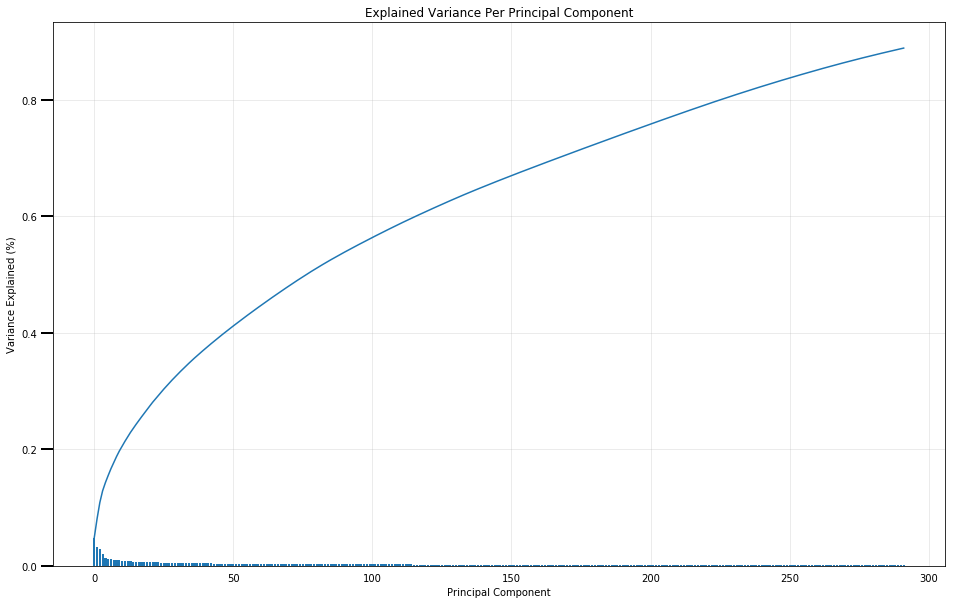

In [139]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [140]:
# Define plot function to check out the ratio of variance explained by each principal component

def plot_variance_ratio(pca):
    '''
    Creates a plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    #cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    #ax.plot(ind, cumvals)
    
    ax.grid()
    ax.set_axisbelow(True)
    ax.grid(linewidth='0.5', alpha=0.5)
   
    # Printing percentage of variance explained by first 5 components.
    for i in range(ind[5]):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

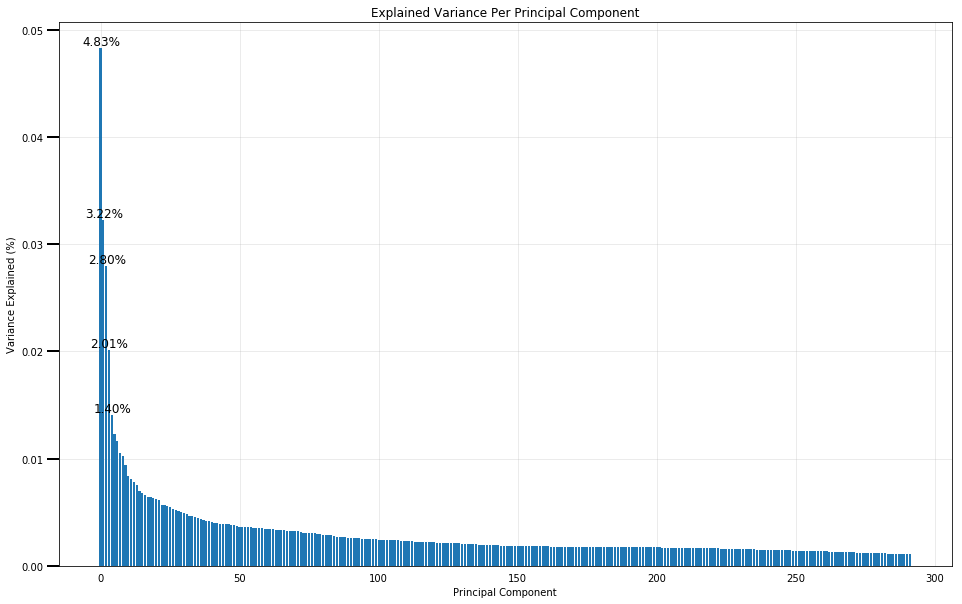

In [141]:
plot_variance_ratio(pca)

In [142]:

# Getting cumulative sum of explained variance ratio.
vals = pca.explained_variance_ratio_
cumvals = list(np.cumsum(vals))
for cmv in enumerate(cumvals):
    print(cmv)

(0, 0.048302950053326431)
(1, 0.080535842483693026)
(2, 0.10854852217235389)
(3, 0.12865560669118442)
(4, 0.14268248249737273)
(5, 0.1549429398170182)
(6, 0.16661631844196076)
(7, 0.17718257181700131)
(8, 0.1873988214822106)
(9, 0.1968049193384579)
(10, 0.20521301400602732)
(11, 0.21335236363458276)
(12, 0.22117184953182611)
(13, 0.22873033338203766)
(14, 0.23568409873476925)
(15, 0.24249120198361651)
(16, 0.24912021127733699)
(17, 0.25555029041934824)
(18, 0.26194812063472139)
(19, 0.26823403140080543)
(20, 0.27447074656773912)
(21, 0.28065219808895847)
(22, 0.28633346929171605)
(23, 0.29200844488696964)
(24, 0.29762476086953221)
(25, 0.30315021342921483)
(26, 0.3084674892464418)
(27, 0.31370488552310566)
(28, 0.31883962270349037)
(29, 0.32382308750002103)
(30, 0.32870467893371319)
(31, 0.33352020967448187)
(32, 0.33819524650229177)
(33, 0.34283548526072999)
(34, 0.34743402150016955)
(35, 0.35193705572200296)
(36, 0.35628995909579225)
(37, 0.36054472263420267)
(38, 0.36472288395070346

In [143]:
# Define plot function to check out cumulative variance explained by principal components.

def plot_cumulative_variance(pca):
    '''
    Creates a plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    #ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.grid()
    ax.set_axisbelow(True)
    ax.grid(linewidth='0.5', alpha=0.5)
    
    cumval_ind_hv1 = []
    cumval_ind_hv2 = []
    cumval_ind_hv3 = []
    cumval_ind_hv4 = []
    cumval_ind_hv5 = []
    cumval_ind_hv6 = []
#    cumval_ind_hv7 = []
    for i in enumerate(cumvals):
        if i[1] > 0.3 and i[1] < 0.4:
            cumval_ind_hv1.append(i)
        elif i[1] > 0.4 and i[1] < 0.5:
            cumval_ind_hv2.append(i)
        elif i[1] > 0.5 and i[1] < 0.6:
            cumval_ind_hv3.append(i)
        elif i[1] > 0.6 and i[1] < 0.7:
            cumval_ind_hv4.append(i)
        elif i[1] > 0.7 and i[1] < 0.8:
            cumval_ind_hv5.append(i)
        elif i[1] > 0.8 and i[1] < 0.9:
            cumval_ind_hv6.append(i)    
#        elif i[1] > 0.9:
#            cumval_ind_hv7.append(i)
            
    #print(cumval_ind_hv1[0][0])
    #print(cumval_ind_hv2[0][0])
    #print(cumval_ind_hv3[0][0])
    #print(cumval_ind_hv4[0][0])
    
    # Plotting horizontal and vertical at points with cumulative variance of 30%, 50%, 60% and 80%.

    plt.hlines(y=0.3, xmin=0, xmax=cumval_ind_hv1[0][0], color='red', linestyles='dashed',zorder=1)
    plt.vlines(x=cumval_ind_hv1[0][0], ymin=0, ymax=0.3, color='red', linestyles='dashed',zorder=2)
    plt.hlines(y=0.4, xmin=0, xmax=cumval_ind_hv2[0][0], color='red', linestyles='dashed',zorder=3)
    plt.vlines(x=cumval_ind_hv2[0][0], ymin=0, ymax=0.4, color='red', linestyles='dashed',zorder=4)
    plt.hlines(y=0.5, xmin=0, xmax=cumval_ind_hv3[0][0], color='red', linestyles='-',zorder=5)
    plt.vlines(x=cumval_ind_hv3[0][0], ymin=0, ymax=0.5, color='red', linestyles='-',zorder=6)
    plt.hlines(y=0.6, xmin=0, xmax=cumval_ind_hv4[0][0], color='red', linestyles='dashed',zorder=7)
    plt.vlines(x=cumval_ind_hv4[0][0], ymin=0, ymax=0.6, color='red', linestyles='dashed',zorder=8)
    plt.hlines(y=0.7, xmin=0, xmax=cumval_ind_hv5[0][0], color='red', linestyles='dashed',zorder=9)
    plt.vlines(x=cumval_ind_hv5[0][0], ymin=0, ymax=0.7, color='red', linestyles='dashed',zorder=10)
    plt.hlines(y=0.8, xmin=0, xmax=cumval_ind_hv6[0][0], color='red', linestyles='dashed',zorder=11)
    plt.vlines(x=cumval_ind_hv6[0][0], ymin=0, ymax=0.8, color='red', linestyles='dashed',zorder=12) 
#    plt.hlines(y=0.9, xmin=0, xmax=cumval_ind_hv7[0][0], color='red', linestyles='dashed',zorder=13)
#    plt.vlines(x=cumval_ind_hv7[0][0], ymin=0, ymax=0.9, color='red', linestyles='dashed',zorder=14)
    
    # Plotting number of components for cumulative variance of 30%, 50%, 60% and 80%.
    for i,v in [cumval_ind_hv1[0], cumval_ind_hv2[0], cumval_ind_hv3[0],\
                cumval_ind_hv4[0], cumval_ind_hv5[0], cumval_ind_hv6[0]]:
        ax.annotate(r"%s" % ((str(i+1))), (i+0.2, np.round(v, 2)), va="bottom", ha="center", fontsize=12)


 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Cumulative Variance of Principal Components')

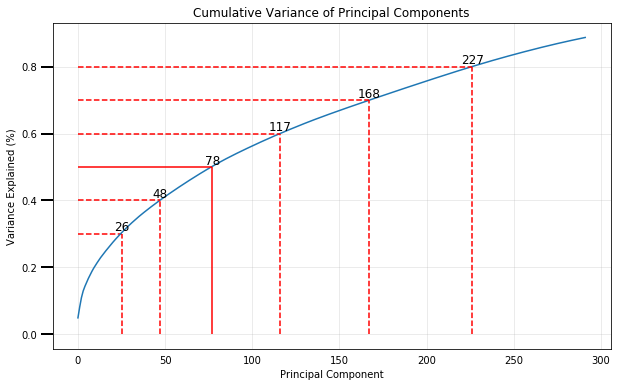

In [144]:
plot_cumulative_variance(pca)

In [145]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_81, azdias_sample_pca = do_pca(81,azdias_sample_scaled)

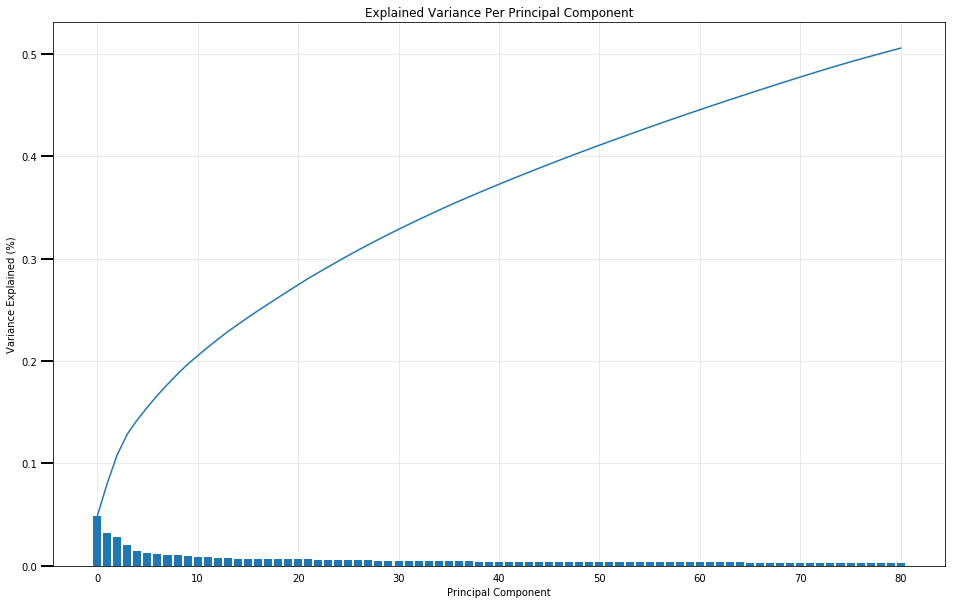

In [146]:
scree_plot(pca_81)

Discussion :  Perform Dimensionality Reduction <br>
Before performing dimensionality reduction we had 584 features in the dataset which were cleaned, imputed, scaled and ready to use. We passed the features through PCA process to obtain principal components in the directions of maximum variance. We then visualized the explained variance ratio per principal components and cumulative variance ratio of principal components.

From the plot of cumulative variance of principal components, we can observe that with every 10% increase of variance, the number of components required for the same increase kept on increasing i.e. to get 10 % increase from 30% to 40% to 50% to 60% to 70% to 80% of the total variance, it required to increase components from 26 to 48 to 78 to 117 to 168 to 227 .

At 78, 117, 168 and 227 principal components, we had 50%, 60%, 70% and 80% of the total variance of the dataset.

Also, from the plot above for explained variance ratio per principal components, we find that first 5 components made for 14% of the total variance in the dataset and first 10 components made for 20% of the total varaince of the dataset. we can observe that difference in explained variance ratio of consective features in 1-80 component interval is much more considerable which tapers off till 80 components after which we can observe that after around 80 features the variance explained levels off and is consistent till around 292 components and between this interval of 80-292 features, the variance explained ratio remain unchanged and is in the range of about 0.002 to 0.003 i.e. between 80-292 interval, difference between explained varaince ratio of consective features differ by 0.002 to 0.003 only which is very low and is not considerable.

Looking at the "Cumulative Explained Variance of Principal Components", there seemed to be a good trade-off at 227 components at which 575 features are reduced to 227(principal components) and still maintained 80% of the dataset variance.

So, proceeding with 81 principal components which explains 50% of the total variance in the dataset and should be helpful to much extent in generalizing the customer segments during cluster analysis process.

 Interpret Principal Components <br>
Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the i-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [147]:
# Principal components of pca_81 in feature space, representing the directions of maximum variance in the data.
pca_81.components_

array([[-0.07009912, -0.01339881,  0.09179772, ...,  0.06594093,
         0.06536801, -0.08334965],
       [ 0.00785385, -0.01635946,  0.05409956, ..., -0.03061121,
         0.02053135,  0.01234735],
       [ 0.0574403 ,  0.02431382,  0.03133388, ..., -0.05478821,
        -0.10630592,  0.08976998],
       ..., 
       [ 0.02034907, -0.05185911,  0.02021271, ...,  0.01993727,
        -0.02131816,  0.00900313],
       [ 0.01519637, -0.02459717,  0.01669033, ..., -0.00230843,
        -0.05597418,  0.05761765],
       [ 0.06539431,  0.08417019,  0.01642249, ...,  0.02400567,
        -0.03967456,  0.04011128]])

In [148]:
# The amount of variance explained by each of the selected component in pca_81.
pca_81.explained_variance_

array([ 27.77438675,  18.53404025,  16.10740127,  11.5616527 ,
         8.06550709,   7.049803  ,   6.71222757,   6.07562055,
         5.87434614,   5.40851022,   4.83456359,   4.67987177,
         4.49611526,   4.34599122,   3.99791707,   3.91350308,
         3.81123111,   3.69675669,   3.677811  ,   3.61349483,
         3.58524449,   3.55376388,   3.26522317,   3.26017452,
         3.22567289,   3.17546999,   3.0528409 ,   3.00727376,
         2.94701852,   2.86193586,   2.79959528,   2.76151328,
         2.67817599,   2.65699213,   2.63443757,   2.57713722,
         2.4910659 ,   2.43470563,   2.3899704 ,   2.36210515,
         2.34918183,   2.30314515,   2.27678359,   2.25575569,
         2.22798443,   2.20901028,   2.18853388,   2.15319433,
         2.13132983,   2.10539314,   2.08358793,   2.06646094,
         2.0444995 ,   2.03386427,   2.01755825,   2.00447399,
         1.99734212,   1.96940413,   1.94311929,   1.93306012,
         1.9161876 ,   1.90526539,   1.88125691,   1.87

In [149]:
# Percentage of variance explained by each of the selected components in pca_81.
pca_81.explained_variance_ratio_

array([ 0.04830295,  0.03223289,  0.02801268,  0.02010708,  0.01402687,
        0.01226044,  0.01167336,  0.01056622,  0.01021618,  0.00940604,
        0.00840788,  0.00813885,  0.00781928,  0.00755819,  0.00695285,
        0.00680605,  0.00662818,  0.0064291 ,  0.00639615,  0.0062843 ,
        0.00623517,  0.00618042,  0.00567861,  0.00566983,  0.00560983,
        0.00552252,  0.00530925,  0.00523001,  0.00512521,  0.00497725,
        0.00486883,  0.0048026 ,  0.00465767,  0.00462082,  0.0045816 ,
        0.00448195,  0.00433226,  0.00423424,  0.00415644,  0.00410798,
        0.00408551,  0.00400544,  0.0039596 ,  0.00392303,  0.00387473,
        0.00384173,  0.00380612,  0.00374466,  0.00370664,  0.00366153,
        0.00362361,  0.00359382,  0.00355563,  0.00353713,  0.00350877,
        0.00348602,  0.00347361,  0.00342503,  0.00337931,  0.00336182,
        0.00333248,  0.00331348,  0.00327173,  0.00325747,  0.00324389,
        0.00320507,  0.00316666,  0.00315975,  0.00314137,  0.00

In [151]:
# Create a dataframe of Explained Variance ratio in pca_81.
dimensions = ['PC {}'.format(i) for i in range(1,len(pca_81.components_)+1)]
ratios = pca_81.explained_variance_ratio_
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['EXPLAINED_VARIANCE RATIO'])
variance_ratios.index = dimensions

In [152]:
variance_ratios

,EXPLAINED_VARIANCE RATIO
PC 1,0.0483
PC 2,0.0322
PC 3,0.0280
PC 4,0.0201
PC 5,0.0140
PC 6,0.0123
PC 7,0.0117
PC 8,0.0106
PC 9,0.0102
PC 10,0.0094


In [153]:
# Create a dataframe with the weights for each principal component in pca_81.
# Map weights for the principal components to corresponding feature names.
components_weights = pd.DataFrame(np.round(pca_81.components_, 4), columns = azdias_sample_scaled.keys())
components_weights.index = dimensions

In [154]:
components_weights.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,...,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage,WOHNLAGE_rural,WOHNLAGE_rating_class
PC 1,-0.0701,-0.0134,0.0918,0.0051,-0.0837,0.0470,0.0607,0.0442,0.0279,0.0511,...,-0.0367,0.0113,-0.0409,-0.0371,-0.0059,-0.0799,-0.1219,0.0659,0.0654,-0.0833
PC 2,0.0079,-0.0164,0.0541,-0.0094,0.0591,0.0354,0.0711,0.0562,0.0187,0.0437,...,-0.0518,0.0553,0.0229,-0.0118,0.0629,0.0660,0.0579,-0.0306,0.0205,0.0123
PC 3,0.0574,0.0243,0.0313,0.0058,0.0333,-0.1088,0.0687,0.0585,0.0047,0.0452,...,-0.0789,0.0602,0.0354,0.0004,0.0975,-0.0264,0.0560,-0.0548,-0.1063,0.0898
PC 4,0.0293,0.0226,0.0230,0.0122,0.0928,-0.0538,0.0083,0.0046,0.0058,0.0129,...,0.1328,-0.0738,-0.0872,-0.0025,-0.1892,-0.0562,0.0341,0.0366,-0.0765,0.0521
PC 5,-0.0066,0.0099,-0.0172,0.0051,0.0894,0.0361,-0.0075,-0.0064,-0.0067,-0.0104,...,-0.0696,0.0204,0.0507,-0.0054,0.0791,-0.0419,-0.0353,0.0750,-0.0120,-0.0204


In [155]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Highest positive and negative weights for the first Principal Componnent

def weights_sorted_p_comp(n_p_comp, n_weights):
    p_comp = 'PC' + ' ' + str(n_p_comp)
    print("Principal Component", (n_p_comp))
    print('-' * 30)
    print("\nTop positive weights are below\n")
    print(components_weights.loc[p_comp].sort_values(ascending=False)[:n_weights])
    print('-' * 30)
    print("\nTop negative weights are below\n")
    print(components_weights.loc[p_comp].sort_values()[:n_weights])

In [156]:
def plot_component_weights(n_p_comp, n_weights):
    '''
    n_p_comp: prinicipal component number
    n_weights: number of top positive and top negative weights
    '''
    p_comp = 'PC' + ' ' + str(n_p_comp)
    comp_weight_first_last = components_weights.loc[p_comp].sort_values(ascending=False)[:n_weights].append(
                                    components_weights.loc[p_comp].sort_values()[:n_weights])
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (10,6))
    comp_weight_first_last.plot(ax = ax, kind = 'bar')

    # Turn on the grid
    ax.grid()
    
    # Don't allow the axis to be on top of your data
    ax.set_axisbelow(True)
    
    # Customize the grid
    ax.grid(linewidth='0.5', alpha=0.5)

    #comp_weight_first_last.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights")
    #ax.set_xticklabels(list(comp_weight_first_last.index), rotation='vertical')
    plt.show()

In [157]:
# Getting top 5 positive and negative weights of a principal component 1.
weights_sorted_p_comp(1, 5)

Principal Component 1
------------------------------

Top positive weights are below

MOBI_REGIO        0.1306
KBA05_ANTG1       0.1228
KBA05_AUTOQUOT    0.1189
PLZ8_ANTG1        0.1170
KBA05_GBZ         0.1151
Name: PC 1, dtype: float64
------------------------------

Top negative weights are below

HH_EINKOMMEN_SCORE       -0.1281
CAMEO_INTL_2015_wealth   -0.1219
LP_STATUS_GROB_1.0       -0.1182
PLZ8_ANTG3               -0.1145
D19_GESAMT_ANZ_24_0      -0.1103
Name: PC 1, dtype: float64


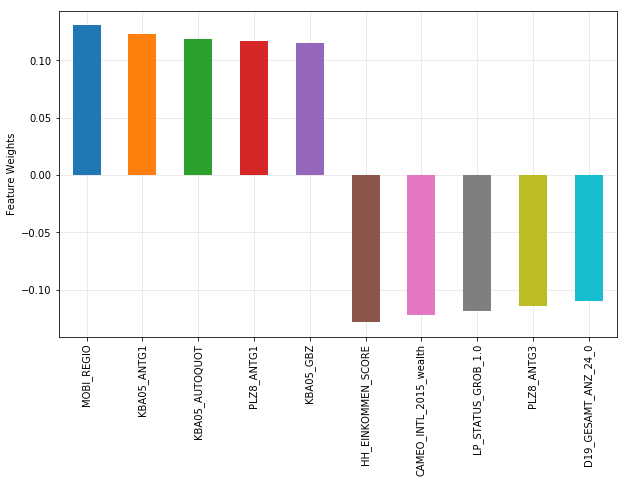

In [158]:
# Plotting the top 5 positive and negative weights of a principal component 1.
plot_component_weights(1, 5)

In [159]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Getting top 5 positive and negative weights of a principal component 2.
weights_sorted_p_comp(2, 5)

Principal Component 2
------------------------------

Top positive weights are below

KBA13_SITZE_5           0.1179
KBA13_SEG_KLEINWAGEN    0.1079
KBA13_KMH_140_210       0.1035
KBA13_KMH_180           0.1024
KBA13_HALTER_25         0.1004
Name: PC 2, dtype: float64
------------------------------

Top negative weights are below

KBA13_HERST_BMW_BENZ          -0.1413
KBA13_MERCEDES                -0.1233
KBA13_SEG_OBEREMITTELKLASSE   -0.1178
KBA13_BMW                     -0.1146
KBA13_SEG_SPORTWAGEN          -0.1094
Name: PC 2, dtype: float64


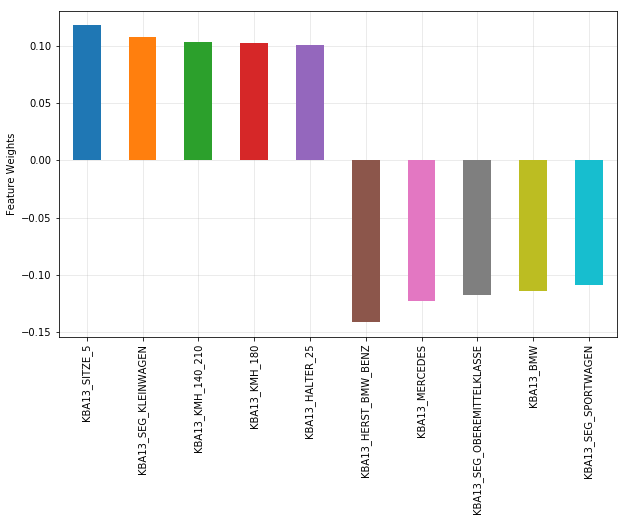

In [160]:
# Plotting the top 5 positive and negative weights of a principal component 2.
plot_component_weights(2, 5)


In [161]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Getting top 5 positive and negative weights of a principal component 3.
weights_sorted_p_comp(3, 5)

Principal Component 3
------------------------------

Top positive weights are below

EWDICHTE                       0.1445
ORTSGR_KLS9                    0.1386
KBA13_HERST_BMW_BENZ           0.1193
KBA13_SEG_OBEREMITTELKLASSE    0.1085
PLZ8_ANTG3                     0.1083
Name: PC 3, dtype: float64
------------------------------

Top negative weights are below

KBA13_ALTERHALTER_60   -0.1315
KBA13_HALTER_55        -0.1195
KBA13_AUTOQUOTE        -0.1162
KBA13_HALTER_50        -0.1139
INNENSTADT             -0.1120
Name: PC 3, dtype: float64


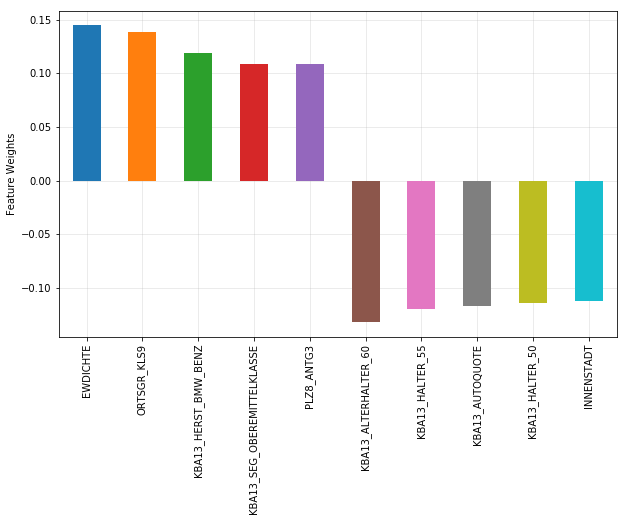

In [162]:
# Plotting the top 5 positive and negative weights of a principal component 3.
plot_component_weights(3, 5)

Interpret Principal Components <br>
The first 5 principal components make up 14.02% of the total variance of the dataset. The first component makes up 4.75% of the total variance.

Each component is a combination of the 584 features left after cleaning, with each feature given a weight relative to its importance for a particular principal component. The higher the weight either positive or negative, the more impact the feature has on the calculation of the principal component. What value of weight is important is subjective and depends on the context.

We have taken the top 5 highest postive weights and negative weights to interpret the first 3 principal components.

The first principal component has positive weights with features mentioned below:

MOBI_REGIO - Movement patterns(higher is lower movement)
KBA05_ANTG1 - Number of 1-2 family houses in the microcell(higher is higher share)
KBA05_AUTOQUOT - Share of cars per household(higher is higher quote)
PLZ8_ANTG1 - Number of 1-2 family houses in the PLZ8 region(higher is higher share)
KBA05_GBZ - Number of buildings in the microcell(higher is more buildings)
The first principal component has negative weights with features mentioned below:

HH_EINKOMMEN_SCORE - Estimated household net income(higher is lower income)
CAMEO_INTL_2015_wealth - Household Wealth Typology(Household wealth (higher is lower household or income)
LP_STATUS_GROB_1.0 - Social status rough(higher is higher earner)
PLZ8_ANTG3 - Number of 6-10 family houses in the PLZ8 region(higher is higher number)
D19_GESAMT_ANZ_24_0 - Transaction activity TOTAL POOL in the last 24 months(higher is higher activity)
First principal component seems to be representing a combination of features that relate to population density in an area and the associated wealth of that area. Positive correlations with increasing population density, movemnet patterns & share of cars per household and negative correlations with Household wealth, financial status & transaction activity in last 24 months. It appears that the first principal component is related to the indiviudal financial status, movement, share of family homes, share of cars per household & transaction activity in last 24 months.

The second principal component have positive weights with features mentioned below:

KBA13_SITZE_5 - number of cars with 5 seats(higher is higher)
KBA13_SEG_KLEINWAGEN - share of small and very small cars(higher is higher)
KBA13_KMH_140_210 - share of cars with max speed between 140 and 210 km/h(higher is higher)
KBA13_KMH_180 - share of cars with max speed between 110 km/h and 180km/h(higher is higher)
KBA13_HALTER_25 - share of car owners between 21 and 25(higher is higher)
The second principal component have negative weights with features mentioned below:

KBA13_HERST_BMW_BENZ - share of BMW & Mercedes Benz(higher is higher)
KBA13_MERCEDES - share of MERCEDES(higher is higher)
KBA13_SEG_OBEREMITTELKLASSE - share of upper middle class cars and upper class cars(higher is higher)
KBA13_BMW - share of BMW(higher is higher)
KBA13_SEG_SPORTWAGEN - share of sportscars(higher is higher)
The second principal component seems to be representing a combination of features related to share of different types of cars in an area & share of car owners. Positive correlations with number of cars having 5 seats which are small in size with maximum speed between 110 to 210 Km/h and share of car owners between 21 and 25 and neagtive correlations with share of upper middle class and upper class cars like BMW, Mercedes Benz & sports cars. It appers that second principal component is related to share of different types of cars in an area and share of number of car owners in an area.

The third principal component have positive weights with features mentioned below:

EWDICHTE - Density of households per square kilometer(higher is higher density)
ORTSGR_KLS9 - Size of community(higher is higher size)
KBA13_HERST_BMW_BENZ - share of BMW & Mercedes Benz(higher is higher)
PLZ8_ANTG3 - Number of 6-10 family houses in the PLZ8 region(higher is higher number)
KBA13_SEG_OBEREMITTELKLASSE - share of upper middle class cars and upper class cars(higher is higher)
The third principal component have negative weights with features mentioned below:

KBA13_ALTERHALTER_60 - share of car owners between 46 and 60(higher is higher)
KBA13_HALTER_55 - share of car owners between 51 and 55(higher is higher)
KBA13_AUTOQUOTE - share of cars per household(higher is higher)
KBA13_HALTER_50 - share of car owners between 46 and 50(higher is higher)
INNENSTADT - distance to the city centre(higher is higher distance)
The third principal component is related to population density in an area, share of cars and car owners in an area & distance to the . Positive correlations with density of households and share of upper middle class cars and upper class cars like BMW & Mercedes Benz and negative correlations with share of cars & car owners along with distance to the city centre. It appears that second principal component is related to share of car owners with respect to share of cars and with respect to population density in an area.

 Clustering<br>
 Apply Clustering to General Population<br>
You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.<br>

Use sklearn's KMeans class to perform k-means clustering on the PCA-transformed data.<br>
Then, compute the average difference from each point to its assigned cluster's center. Hint: The KMeans object's .score() method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.<br>
Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. Warning: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.<br>
Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step <br>

In [163]:
# Printing type of azdias_sample_pca
type(azdias_sample_pca)

numpy.ndarray

In [164]:
# Printing shape of azdias_sample_pca
azdias_sample_pca.shape

(145818, 81)

In [165]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [166]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

scores = []
centers = list(range(2,26,1))

for center in centers:
    score = round(get_kmeans_score(azdias_sample_pca, center),2)
    print('center : {}     score : {}'.format(center, score))
    scores.append(score)

center : 2     score : 39584391.28
center : 3     score : 38063370.71
center : 4     score : 37168725.95
center : 5     score : 36455716.63
center : 6     score : 35900682.82
center : 7     score : 35439037.43
center : 8     score : 35055570.85
center : 9     score : 34718674.41
center : 10     score : 34396839.57
center : 11     score : 34117457.41
center : 12     score : 33841969.44
center : 13     score : 33553512.39
center : 14     score : 33378616.56
center : 15     score : 33092973.74
center : 16     score : 32826389.67
center : 17     score : 32635827.26
center : 18     score : 32388248.85
center : 19     score : 32271608.55
center : 20     score : 32033365.66
center : 21     score : 31714953.41
center : 22     score : 31661768.84
center : 23     score : 31401457.95
center : 24     score : 31240365.24
center : 25     score : 31024147.09


In [167]:
# Create dataframe showing the average point-centroid distances
scores_ds = pd.Series(scores).round(2)
centers_ds = pd.Series(centers)
average_distance = np.array(scores)/azdias_sample_pca.shape[0]
average_distance_ds = pd.Series(average_distance).round(2)

scores_df = pd.concat([centers_ds, scores_ds, average_distance_ds],axis=1)
scores_df.columns = ['clusters','score','average_distance']
scores_df.set_index('clusters',inplace=True)
#scores_df['score'] = scores_df['score'].round(2)
scores_df

,score,average_distance
clusters,,
2,39584391.28,271.46
3,38063370.71,261.03
4,37168725.95,254.90
5,36455716.63,250.01
6,35900682.82,246.20
7,35439037.43,243.04
8,35055570.85,240.41
9,34718674.41,238.10
10,34396839.57,235.89


In [168]:
# Save checkpoint
#scores_df.to_csv('scores_checkpoint.csv', encoding='utf-8',index=False)
scores_df.to_csv('scores_checkpoint.csv', encoding='utf-8')

In [169]:
# Load scores_checkpoint.csv
scores_df = pd.read_csv('scores_checkpoint.csv')
scores_df.set_index('clusters',inplace=True)
scores_df

,score,average_distance
clusters,,
2,39584391.28,271.46
3,38063370.71,261.03
4,37168725.95,254.90
5,36455716.63,250.01
6,35900682.82,246.20
7,35439037.43,243.04
8,35055570.85,240.41
9,34718674.41,238.10
10,34396839.57,235.89


In [170]:
# Create list of centers, scores, avg_point_centroid_dist
centers =  list(scores_df.index)
scores = scores_df['score'].values.tolist()
avg_point_centroid_dist = scores_df['average_distance'].values.tolist()

In [171]:
print(type(centers))
print(type(scores))
print(type(list(avg_point_centroid_dist)))

<class 'list'>
<class 'list'>
<class 'list'>


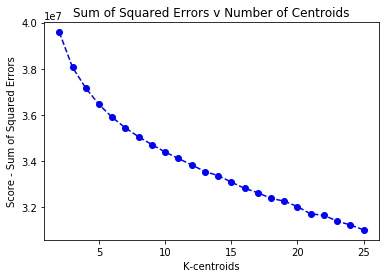

In [172]:
# Investigate the change in sse across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K-centroids');
plt.ylabel('Score - Sum of Squared Errors');
plt.title('Sum of Squared Errors v Number of Centroids');

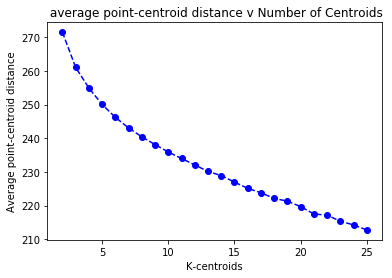

In [173]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, avg_point_centroid_dist, linestyle='--', marker='o', color='b');
plt.xlabel('K-centroids');
plt.ylabel('Average point-centroid distance');
plt.title(' average point-centroid distance v Number of Centroids');

In [174]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.


#instantiate kmeans
kmeans_10 = KMeans(n_clusters=10, n_init=10, max_iter=300, random_state=42)

# Then fit the model to your data using the fit method
model_general = kmeans_10.fit(azdias_sample_pca)

# Finally predict the labels or clusters on the same data using the predict method 
predict_general_clusters = model_general.predict(azdias_sample_pca)

In [175]:
# Print clusters for first 5 observations in azdias_sample_pca
predict_general_clusters[:5]

array([5, 2, 6, 9, 0], dtype=int32)

In [176]:
# Total number of predictions for sample general population data
len(predict_general_clusters)


145818

In [177]:
# Total number of unique clusters in sample general population data
np.unique(predict_general_clusters)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [178]:
# Distribution of general population sample data in clusters
pd.Series(predict_general_clusters).value_counts().sort_index()

0    15241
1    10800
2     8523
3    17450
4    17876
5    15016
6    13360
7    14441
8    16593
9    16518
dtype: int64

 Apply Clustering to General Population <br>
From the above plot of score(SSE) vs. K-centroids, we can observe that the average within-cluster distances from each point to their assigned cluster's centroid decreases with increasing number of clusters. However, the rate of change of slope decreases with additional cluster i.e. each additional cluster provides a smaller net benefit.<br>

Running the K-Means algorithm with 81 principal components didn't provided any defined and clear "elbow". Possible cluster candidates are 6, 7, 10, 11, 16, 17, 20 and 21 depending if you take a high "elbow" at 6 or 7 clusters, "middle" elbow at 10 or 11 clusters or low "elbow" at 16 or 17 clusters.<br><br>

The rate of change of slope was substantial till 7 clusters and starts to be consistent around 7 clusters and additional clusters later on provided a smaller net benefit. In general, lower number of clusters could provide more equal distribution in the population clustering of the dataset, whereas a higher number of clusters could result in the population clustering having some wide differences between counts allocated to clusters. Keeping the above points in mind, we could take 10 clusters as a choice to segment the population generally.<br>

Apply All Steps to the Customer Data <br>
Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.<br>

Don't forget when loading in the customers data, that it is semicolon (;) delimited.<br>
Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the clean_data() function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)<br>
Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a .fit() or .fit_transform() method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.<br>

In [179]:
# Shape of customers df after removal of 3 extra columns
customers.shape

(191652, 366)

In [180]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean Customers subset file.
customers_cleaned = clean_data(customers)

In [181]:
# Print type of customers_cleaned
type(customers_cleaned)

pandas.core.frame.DataFrame

In [182]:
# Shape of customers demographic dataset after cleaning 
customers_cleaned.shape

(130661, 575)

In [183]:
# Checking if columns of customers_cleaned and azdias_sample are same or not
len(set(customers_cleaned.columns).intersection(azdias_sample.columns))

575

In [184]:
# Impute nans with mode value in customers_cleaned dataframe
# Apply imputer to transform customer dataframe
customers_cleaned_imputed = imputer.transform(customers_cleaned)
print('Type of customers_cleaned_imputed is : {}'.format(type(customers_cleaned_imputed)))

# Making customers_cleaned_imputed into a dataframe
customers_cleaned_imputed = pd.DataFrame(customers_cleaned_imputed)
print('Type of customers_cleaned_imputed now is : {}'.format(type(customers_cleaned_imputed)))
customers_cleaned_imputed.head()

Type of customers_cleaned_imputed is : <class 'numpy.ndarray'>
Type of customers_cleaned_imputed now is : <class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,...,565,566,567,568,569,570,571,572,573,574
0,1.0,0.0,2.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,0.0,1.0,3.0,1.0,0.0
1,1.0,0.0,1.0,0.0,3.0,7.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,0.0,3.0,4.0,0.0,2.0
2,1.0,0.0,0.0,0.0,1.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,2.0,4.0,1.0,0.0
3,7.0,0.0,4.0,0.0,3.0,3.0,5.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,4.0,1.0,4.0,1.0,0.0,3.0
4,1.0,0.0,2.0,0.0,3.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,3.0,4.0,0.0,1.0


In [185]:
# Checking the sum of all misisng values in the customers_cleaned_imputed.
# It should be 0 as we have already imputed the missing value with mode value.
sum(customers_cleaned_imputed.isnull().sum(axis=1))

0

In [186]:

# Apply feature scaling to the customers demographics data.
# Apply scaler to transform customer dataframe

customers_scaled = scaler.transform(customers_cleaned_imputed)
print('Type of customers_scaled is : {}'.format(type(customers_scaled)))

# Making azdias_scaled into a dataframe
customers_scaled = pd.DataFrame(customers_scaled, columns= list(customers_cleaned.columns.values))
print('Type of customers_scaled now is : {}'.format(type(customers_scaled)))
customers_scaled.head()

Type of customers_scaled is : <class 'numpy.ndarray'>
Type of customers_scaled now is : <class 'pandas.core.frame.DataFrame'>


,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,...,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage,WOHNLAGE_rural,WOHNLAGE_rating_class
0,-0.474852,-0.123417,0.220156,-0.062039,-2.195637,-0.521179,-0.467054,-0.361868,-0.135111,-0.293792,...,1.352162,-0.599071,-0.337095,-0.314214,-1.609760,-1.864910,-1.558050,0.088621,1.825189,-1.491173
1,-0.474852,-0.123417,-0.637724,-0.062039,-0.182866,1.307524,-0.467054,-0.361868,-0.135111,-0.293792,...,1.352162,-0.599071,-0.337095,-0.314214,-1.609760,-1.864910,-0.194538,0.758950,-0.547889,-0.259850
2,-0.474852,-0.123417,-1.495603,-0.062039,-2.195637,1.307524,-0.467054,-0.361868,-0.135111,-0.293792,...,-0.739556,-0.599071,-0.337095,-0.314214,-2.292812,0.536219,-0.876294,0.758950,1.825189,-1.491173
3,-0.079518,-0.123417,1.935915,-0.062039,-0.182866,-0.521179,1.931309,-0.361868,3.490722,-0.293792,...,-0.739556,-0.599071,-0.337095,-0.314214,-0.243657,0.536219,0.487218,-1.252036,-0.547889,0.355811
4,-0.474852,-0.123417,0.220156,-0.062039,-0.182866,1.307524,-0.467054,-0.361868,-0.135111,-0.293792,...,-0.739556,-0.599071,-0.337095,-0.314214,-1.609760,-1.864910,-0.194538,0.758950,-0.547889,-0.875512


In [187]:

# Apply PCA to the customers_scaled data
# Apply general population Principal Component transformation on customers_scaled dataframe

customers_pca = pca_81.transform(customers_scaled)


In [188]:
type(customers_pca)

numpy.ndarray

In [189]:
# Shape of customers_pca
customers_pca.shape

(130661, 81)

In [190]:
# Apply fitted kmeans object from general population demographics onto the customer data,
# obtaining cluster predictions for the customer demographics data.

predict_customers_clusters = model_general.predict(customers_pca)

In [191]:
# Print clusters for first 5 observations in clustomers_cleaned
predict_customers_clusters[:5]

array([5, 1, 3, 2, 1], dtype=int32)

In [192]:
# Total number of predictions for customers_cleaned data
len(predict_customers_clusters)

130661

In [193]:
# Total number of unique clusters in customers_cleaned data
np.unique(predict_customers_clusters)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [194]:

# Distribution of customers_cleaned data in clusters
pd.Series(predict_customers_clusters).value_counts().sort_index()

0     1375
1    11049
2     8784
3    19205
4    13681
5    46305
6     4537
7     3560
8      797
9    21368
dtype: int64

Compare Customer Data to Demographics Data <br>
At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's countplot() or barplot() function could be handy.
Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the .inverse_transform() method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [195]:

# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Number of data points within each general population cluster.
population_clusters = pd.Series(predict_general_clusters)
count_pc = population_clusters.value_counts().sort_index()
print(type(count_pc))
count_pc

<class 'pandas.core.series.Series'>


0    15241
1    10800
2     8523
3    17450
4    17876
5    15016
6    13360
7    14441
8    16593
9    16518
dtype: int64

In [196]:

# Number of data points within each customers cluster.
customers_clusters = pd.Series(predict_customers_clusters)
count_cc = customers_clusters.value_counts().sort_index()
print(type(count_cc))
count_cc

<class 'pandas.core.series.Series'>


0     1375
1    11049
2     8784
3    19205
4    13681
5    46305
6     4537
7     3560
8      797
9    21368
dtype: int64

In [197]:
# Create a dataframe from counts of data points within each population and customer clusters.
pop_cust_clusters_data_count_df = pd.concat([count_pc, count_cc], axis=1).reset_index()
pop_cust_clusters_data_count_df.columns = ['cluster', 'population', 'customer']
#pop_cust_clusters_data_count_df.index.name = 'cluster'
pop_cust_clusters_data_count_df

,cluster,population,customer
0,0,15241,1375
1,1,10800,11049
2,2,8523,8784
3,3,17450,19205
4,4,17876,13681
5,5,15016,46305
6,6,13360,4537
7,7,14441,3560
8,8,16593,797
9,9,16518,21368


In [198]:
# Add ratio and ratio difference for each cluster to the dataframe
pop_cust_clusters_data_count_df['pop_%'] = (pop_cust_clusters_data_count_df['population']\
                                            /pop_cust_clusters_data_count_df['population'].sum()*100).round(2)
pop_cust_clusters_data_count_df['cust_%'] = (pop_cust_clusters_data_count_df['customer']\
                                             /pop_cust_clusters_data_count_df['customer'].sum()*100).round(2)
pop_cust_clusters_data_count_df['diff'] = pop_cust_clusters_data_count_df['cust_%'] - pop_cust_clusters_data_count_df['pop_%']
pop_cust_clusters_data_count_df

,cluster,population,customer,pop_%,cust_%,diff
0,0,15241,1375,10.45,1.05,-9.40
1,1,10800,11049,7.41,8.46,1.05
2,2,8523,8784,5.84,6.72,0.88
3,3,17450,19205,11.97,14.70,2.73
4,4,17876,13681,12.26,10.47,-1.79
5,5,15016,46305,10.30,35.44,25.14
6,6,13360,4537,9.16,3.47,-5.69
7,7,14441,3560,9.90,2.72,-7.18
8,8,16593,797,11.38,0.61,-10.77
9,9,16518,21368,11.33,16.35,5.02


In [199]:
# General population data with missing values in row(rows with more than 8 missing values)
azdias_null_data_row_high.shape[0]


0

In [200]:
# Taking 20% of the missing rows from population dataset as our sample is 20% of the population
# dataset with 8 or less than 8 missing values
round(azdias_null_data_row_high.shape[0]*.20)

0

In [201]:
# Missing rows from customer dataset
customers_null_data_row_few = customers[customers.isnull().sum(axis=1) < 9].reset_index(drop=True)
customers_null_data_row_high = customers[customers.isnull().sum(axis=1) >= 9].reset_index(drop=True)

In [202]:

customers.shape[0]

191652

In [203]:
customers_null_data_row_high.shape[0]


60991

In [204]:
customers_null_data_row_few.shape[0] + customers_null_data_row_high.shape[0]

191652

In [205]:
# Add missing data rows as an extra cluster to pop_cust_clusters_data_count_df dataframe
pop_cust_clusters_data_count_df.loc[-1] = ['-1', round(azdias_null_data_row_high.shape[0]*.20),\
                                           customers_null_data_row_high.shape[0],0,0,0]  # adding a row
pop_cust_clusters_data_count_df.index = pop_cust_clusters_data_count_df.index + 1  # shifting index
pop_cust_clusters_data_count_df.sort_index(inplace=True)

In [206]:
# Recalculate ratios and differences
pop_cust_clusters_data_count_df['pop_%'] = (pop_cust_clusters_data_count_df['population']\
                                            /pop_cust_clusters_data_count_df['population'].sum()*100).round(2)
pop_cust_clusters_data_count_df['cust_%'] = (pop_cust_clusters_data_count_df['customer']\
                                             /pop_cust_clusters_data_count_df['customer'].sum()*100).round(2)
pop_cust_clusters_data_count_df['diff'] = pop_cust_clusters_data_count_df['cust_%'] - pop_cust_clusters_data_count_df['pop_%']

pop_cust_clusters_data_count_df

,cluster,population,customer,pop_%,cust_%,diff
0,-1,0,60991,0.00,31.82,31.82
1,0,15241,1375,10.45,0.72,-9.73
2,1,10800,11049,7.41,5.77,-1.64
3,2,8523,8784,5.84,4.58,-1.26
4,3,17450,19205,11.97,10.02,-1.95
5,4,17876,13681,12.26,7.14,-5.12
6,5,15016,46305,10.30,24.16,13.86
7,6,13360,4537,9.16,2.37,-6.79
8,7,14441,3560,9.90,1.86,-8.04
9,8,16593,797,11.38,0.42,-10.96


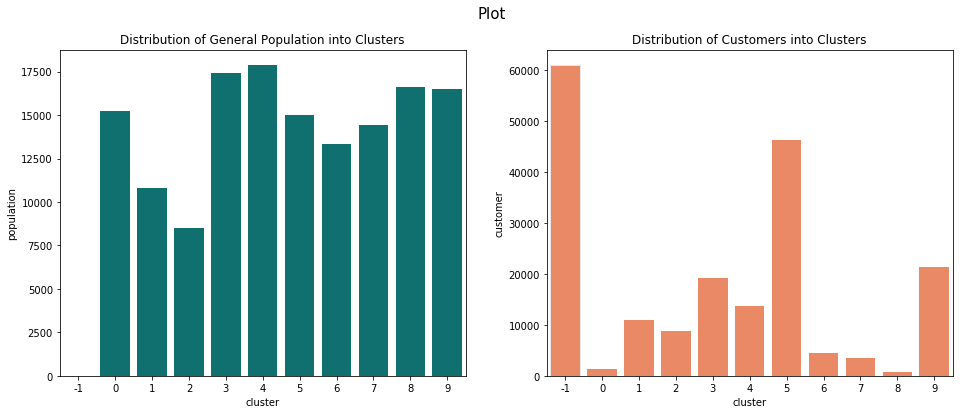

In [208]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.barplot(x=pop_cust_clusters_data_count_df['cluster'],\
                  y=pop_cust_clusters_data_count_df['population'],\
                  color='teal',edgecolor='.9')
plt.title("Distribution of General Population into Clusters")

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.barplot(x=pop_cust_clusters_data_count_df['cluster'],\
                  y=pop_cust_clusters_data_count_df['customer'],\
                  color='coral',edgecolor='.9')

plt.title("Distribution of Customers into Clusters")
plt.suptitle("Plot", fontsize=15);

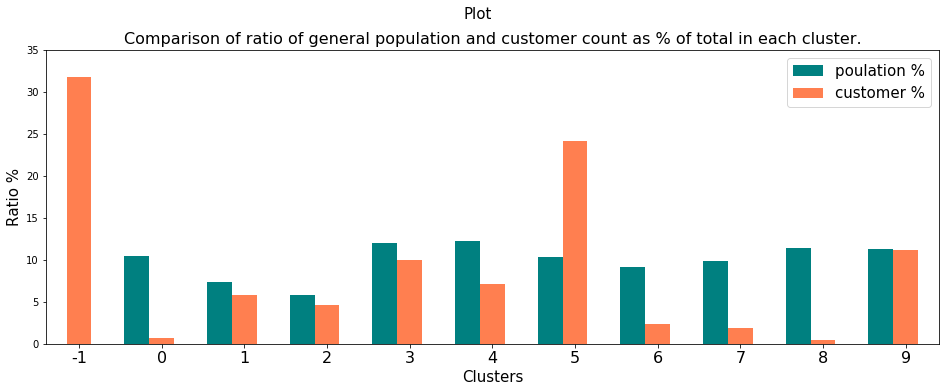

In [209]:

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(111)

ax = pop_cust_clusters_data_count_df['pop_%'].plot(x=pop_cust_clusters_data_count_df['cluster'], kind='bar',\
                                                   color='teal',width=-0.3, align='edge',position=0)
ax = pop_cust_clusters_data_count_df['cust_%'].plot(x=pop_cust_clusters_data_count_df['cluster'], kind='bar',\
                                                    color='coral',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels= pop_cust_clusters_data_count_df['cluster'])
ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.xticks(rotation=360,)

plt.legend(('poulation %', 'customer %'),fontsize=15)
plt.title(('Comparison of ratio of general population and customer count as % of total in each cluster.')
          ,fontsize=16)

plt.subplots_adjust(bottom=0.2)
plt.suptitle("Plot", fontsize=15)
plt.show()


From the above visualization, we can observe that there is a proportion difference of +15.69% between customer proportion and genarl population proportion assigned to cluster 9. Therefore, cluster 9 over-represents customer data compared to general population.

Also, we can observe that there is a proportion difference of -8.90% between customer proportion and general population proportion assigned to cluster 8. Therefore, cluster 8 under-represents customer data compared to general population.

In [210]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


# Analysis of principal components of cluster 9 consisting of people with over-representation in the
# customer data compared to the general population.
p_comp_cluster_9 = pd.Series(kmeans_10.cluster_centers_[9])
p_comp_cluster_9.index = p_comp_cluster_9.index + 1
p_comp_cluster_9.sort_values(ascending=False, inplace=True)
p_comp_cluster_9

1     7.270695
2     2.984870
24    0.613113
10    0.588447
22    0.508739
3     0.425988
18    0.386389
13    0.296758
26    0.267515
43    0.205152
27    0.185726
48    0.153480
41    0.149116
40    0.144191
39    0.135785
42    0.133133
46    0.130782
33    0.129233
35    0.121644
56    0.108874
47    0.100656
66    0.090633
58    0.081110
74    0.078970
49    0.072862
30    0.069672
45    0.063473
34    0.056034
60    0.052370
50    0.047099
        ...   
75   -0.035661
25   -0.045819
72   -0.051753
16   -0.066643
38   -0.067787
8    -0.068121
55   -0.074532
59   -0.077789
65   -0.078161
70   -0.083216
7    -0.101691
52   -0.130956
29   -0.151218
54   -0.157192
21   -0.173676
6    -0.231520
32   -0.288293
20   -0.299179
19   -0.322580
31   -0.324020
5    -0.349460
15   -0.358545
17   -0.407622
23   -0.428180
28   -0.454867
4    -0.514579
14   -0.659356
9    -0.787504
12   -0.990914
11   -1.270688
Length: 81, dtype: float64

In [211]:
azdias_sample.columns

Index(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'ARBEIT', 'BALLRAUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_REST',
       ...
       'ZABEOTYP_3', 'ZABEOTYP_4', 'ZABEOTYP_5', 'ZABEOTYP_6',
       'PRAEGENDE_JUGENDJAHRE_decade', 'PRAEGENDE_JUGENDJAHRE_movement',
       'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life_stage',
       'WOHNLAGE_rural', 'WOHNLAGE_rating_class'],
      dtype='object', length=575)

In [212]:
# Transform cluster 1 principal components to original feature values.
p_comp_cluster_9_orig = pd.Series(scaler.inverse_transform(pca_81.inverse_transform(p_comp_cluster_9)))
p_comp_cluster_9_orig = p_comp_cluster_9_orig.round(2)
p_comp_cluster_9_orig.index = azdias_sample.columns
p_comp_cluster_9_orig

ANZ_HAUSHALTE_AKTIV              -0.85
ANZ_HH_TITEL                      0.00
ANZ_PERSONEN                      2.65
ANZ_TITEL                         0.02
ARBEIT                            2.85
BALLRAUM                          4.87
D19_BANKEN_DIREKT                 2.67
D19_BANKEN_GROSS                  1.58
D19_BANKEN_LOKAL                  0.23
D19_BANKEN_REST                   1.22
D19_BEKLEIDUNG_GEH                1.35
D19_BEKLEIDUNG_REST               2.75
D19_BILDUNG                       1.55
D19_BIO_OEKO                      1.03
D19_BUCH_CD                       3.71
D19_DIGIT_SERV                    0.60
D19_DROGERIEARTIKEL               1.82
D19_ENERGIE                       0.87
D19_FREIZEIT                      1.79
D19_GARTEN                        0.86
D19_HANDWERK                      2.31
D19_HAUS_DEKO                     2.81
D19_KINDERARTIKEL                 2.42
D19_KOSMETIK                      2.62
D19_LEBENSMITTEL                  1.05
D19_NAHRUNGSERGAENZUNG   

In [213]:
# Analyze top principal component in cluster 9
# Getting top 5 positive and negative weights of a principal component 1.
weights_sorted_p_comp(1, 5)

Principal Component 1
------------------------------

Top positive weights are below

MOBI_REGIO        0.1306
KBA05_ANTG1       0.1228
KBA05_AUTOQUOT    0.1189
PLZ8_ANTG1        0.1170
KBA05_GBZ         0.1151
Name: PC 1, dtype: float64
------------------------------

Top negative weights are below

HH_EINKOMMEN_SCORE       -0.1281
CAMEO_INTL_2015_wealth   -0.1219
LP_STATUS_GROB_1.0       -0.1182
PLZ8_ANTG3               -0.1145
D19_GESAMT_ANZ_24_0      -0.1103
Name: PC 1, dtype: float64


In [214]:
# Analyze second top principal component in cluster 9
# Getting top 5 positive and negative weights of a principal component 4.
weights_sorted_p_comp(4, 5)

Principal Component 4
------------------------------

Top positive weights are below

ALTERSKATEGORIE_GROB    0.1851
FINANZ_VORSORGER        0.1685
SEMIO_ERL               0.1370
SEMIO_LUST              0.1348
ZABEOTYP_3              0.1328
Name: PC 4, dtype: float64
------------------------------

Top negative weights are below

FINANZ_SPARER                  -0.1950
PRAEGENDE_JUGENDJAHRE_decade   -0.1892
SEMIO_PFLICHT                  -0.1813
FINANZ_UNAUFFAELLIGER          -0.1809
SEMIO_REL                      -0.1806
Name: PC 4, dtype: float64


In [215]:


# Analysis of principal components of cluster 8 consisting of people with under-representation in the
# customer data compared to the general population.
p_comp_cluster_8 = pd.Series(kmeans_10.cluster_centers_[8])
p_comp_cluster_8.index = p_comp_cluster_8.index + 1
p_comp_cluster_8.sort_values(ascending=False, inplace=True)
p_comp_cluster_8


5     1.030003
7     0.863926
16    0.357109
23    0.262405
22    0.220077
17    0.204410
32    0.184990
20    0.167274
67    0.107584
14    0.105203
80    0.100731
25    0.093717
42    0.081299
11    0.076853
79    0.073015
44    0.070002
39    0.066173
66    0.065133
45    0.059659
29    0.053041
75    0.047880
73    0.045749
37    0.039782
47    0.039458
13    0.038298
52    0.032220
72    0.029891
33    0.028544
63    0.024266
64    0.022621
        ...   
71   -0.031089
70   -0.031605
19   -0.033754
78   -0.036538
53   -0.038776
54   -0.040204
26   -0.051204
57   -0.052667
41   -0.056782
68   -0.057871
74   -0.061943
34   -0.066729
40   -0.069140
36   -0.081513
50   -0.109987
31   -0.133939
35   -0.136033
12   -0.195459
28   -0.202395
30   -0.211126
27   -0.265063
15   -0.270840
24   -0.315472
10   -0.380819
8    -0.411705
6    -0.531686
3    -0.749098
1    -1.270362
2    -1.460392
4    -4.739089
Length: 81, dtype: float64

In [216]:
# Transform cluster 8 principal components to original feature values.
p_comp_cluster_8_orig = pd.Series(scaler.inverse_transform(pca_81.inverse_transform(p_comp_cluster_8)))
p_comp_cluster_8_orig = p_comp_cluster_8_orig.round(2)
p_comp_cluster_8_orig.index = azdias_sample.columns
p_comp_cluster_8_orig

ANZ_HAUSHALTE_AKTIV               1.42
ANZ_HH_TITEL                     -0.05
ANZ_PERSONEN                      1.76
ANZ_TITEL                         0.01
ARBEIT                            3.05
BALLRAUM                          4.26
D19_BANKEN_DIREKT                 1.74
D19_BANKEN_GROSS                  0.93
D19_BANKEN_LOKAL                  0.03
D19_BANKEN_REST                   0.48
D19_BEKLEIDUNG_GEH                0.76
D19_BEKLEIDUNG_REST               1.36
D19_BILDUNG                       1.24
D19_BIO_OEKO                      0.77
D19_BUCH_CD                       2.45
D19_DIGIT_SERV                    0.33
D19_DROGERIEARTIKEL               0.64
D19_ENERGIE                       0.42
D19_FREIZEIT                      0.97
D19_GARTEN                        0.53
D19_HANDWERK                      1.50
D19_HAUS_DEKO                     1.57
D19_KINDERARTIKEL                 1.33
D19_KOSMETIK                      1.59
D19_LEBENSMITTEL                  0.63
D19_NAHRUNGSERGAENZUNG   

In [217]:
# Getting top 5 positive and negative weights of a principal component 5.
weights_sorted_p_comp(5, 5)

Principal Component 5
------------------------------

Top positive weights are below

KBA13_VORB_0        0.1636
KBA13_KW_61_120     0.1455
KBA13_SITZE_5       0.1388
KBA13_KRSZUL_NEU    0.1205
KBA05_VORB0         0.1127
Name: PC 5, dtype: float64
------------------------------

Top negative weights are below

KBA13_BJ_2000   -0.1781
OST_WEST_KZ     -0.1708
KBA13_KW_0_60   -0.1597
KBA13_BJ_1999   -0.1380
KBA13_SITZE_6   -0.1337
Name: PC 5, dtype: float64


In [218]:
# Analyze second top principal component in cluster 8
# Getting top 5 positive and negative weights of a second top principal component 7.
weights_sorted_p_comp(7, 5)

Principal Component 7
------------------------------

Top positive weights are below

KBA05_SEG2        0.2260
KBA05_KRSKLEIN    0.2122
KBA05_CCM1        0.2044
KBA05_MOD4        0.1820
KBA05_KW1         0.1645
Name: PC 7, dtype: float64
------------------------------

Top negative weights are below

KBA05_MAXSEG             -0.1752
KBA05_KW2                -0.1525
KBA13_SEG_MITTELKLASSE   -0.1513
KBA05_SEG4               -0.1309
KBA13_ALTERHALTER_30     -0.1280
Name: PC 7, dtype: float64


Compare Customer Data to Demographics Data <br>
Compare the Population and Customer clusters without consideration of the missing row data.
If we compare the Population and Customer clusters without consideration of the missing row data, we can observe the below -

General Population dataset has highest count(17921) of observations in cluster 2 and has lowest count(8535) of observations in cluster 1. Customer dataset has highest count(46202) of observations in cluster 9 and lowest count(815) in cluster 8.

From plot in analysis, we can observe that there is a difference in the cluster distributions between the general population and the customer dataset. Looking at the ratios of each cluster against total counts in order to make better comparisons, we can see the customer dataset is over-represented in clusters 9 and 5 with greater than 5% ratio difference to the general population, and under-represented in clusters 8, 0, 4 and 7 with 5% ratio difference to the general population.

This can be seen in  above Plot where the significance of cluster 9 customer segment to the mail order company's customer base is clearly visible.

However, to make this analysis more complete, we should also include the missing row data as an additional cluster,we found that the rows of missing data were qualitatively different to the the rows kept for the analysis.

Compare the Population and Customer clusters with consideration of the missing row data.
If we compare the Population and Customer clusters with consideration of the missing row data, we can observe the below -

we have assigned missing row data to cluster -1.



General Population dataset has 162135 rows with missing data(where number of missing values in each row is greater than 8). Now, we have used sample dataset from general population dataset in our analysis. we have used 20 % sample dataset which is representative of the general population data. Therefore, 20 % of the missing row data for the population dataset would be 32427 and it represented 18.19% of the general population data.

Customer dataset has 60991 rows with missing data(where number of missing values in each row is greater than 8). The missing row data for the customer dataset represented 31.82% of the total customer data.

If we take +5% threshold of ratio difference for determining over-representation and -5% threshold of ratio difference for determining under-representation, the customer dataset is over-represented in cluster 9(15.69%) and cluster -1(13.63%), and under-represented in clusters 8(-8.90%), 0(-7.84%), 4(-6.23%) and 7(-5.14%).

So, from the above, customer data is over-represented in cluster 9 and under-represented in cluster 8.

The missing row data requires more investigation and analysis but from the preliminary bar charts constructed in step above, this data seems to represent conservative, minimilistic high-income earners receptive to advertising incentives and is a relevant customer segment for targeting for the mail order company.

Analysis for Cluster that is over-represented in the customer data is below -
Cluster 9 is the most relevant cluster for the mail order company's customer base. If we analyze the features that make up this cluster by inverse transforming the principal components and inverse scaling we obtain values for the cluster centroid for our original features(after data wrangling step earlier) that we can use to create a picture of the customer segment. We can also determine the most important features by looking at the principal components that have the biggest impact on the cluster and then analyzing which features make up the largest positive and negative weights of this principal component as we did in step 2.3.

For cluster 9, the main principal component is number component 1 that has a value of 4.77 followed by component number 4, 6, 7 and 5 with values of 2.12, 1.10, 0.84 and 0.67 respectively. From this we can see principal components 1 has the biggest influence.

Top 5 positive weights for component 1 are -

MOBI_REGIO, feature value = 3.52, signifies low to medium moving patterns, KBA05_ANTG1, feature value = 2.02, signifies average share of 1-2 family homes, KBA05_AUTOQUOT, feature value = 3.16, signifies average share of cars per household, PLZ8_ANTG1, feature value = 2.50, signifies average number of 1-2 family houses in the PLZ8, KBA05_GBZ, feature value = 3.56, signifies 5-16 number of buildings in the microcell,

Top 5 negative weights for component 1 are -

HH_EINKOMMEN_SCORE, feature value = 3.62, signifies high estimated household net income, CAMEO_INTL_2015_wealth, feature Value = 2.27, signifies Prosperous Households, LP_STATUS_GROB_1.0, feature value = 0.15, signifies low-income earners, PLZ8_ANTG3, feature value = 1.40, signifies low share of number of 6-10 family houses in the PLZ8, D19_GESAMT_ANZ_24_0, feature value = signifies no transaction activity TOTAL POOL in the last 24 months,

Top 5 positive weights for component 4 are -

ALTERSKATEGORIE_GROB, feature value = 2.70, signifies age classification from 30 - 60 years, FINANZ_VORSORGER, feature value = 2.85, signifies average financial topology, SEMIO_ERL, feature value = 4.39, signifies average affinity indicating in what way the person is eventful orientated, SEMIO_LUST, feature value = 4.0, signifies average affinity indicating in what way the person is sensual minded, ZABEOTYP_3, feature value = 0.14, signifies green energy consumers,

Top 5 negative weights for component 4 are -

FINANZ_SPARER, feature value = 2.91, signifies average money , PRAEGENDE_JUGENDJAHRE_decade, feature value = 4.83, signifies 80's decade , SEMIO_PFLICHT, feature value = 4.16, signifies average affinity indicating in what way the person is dutyfull traditional minded , FINANZ_UNAUFFAELLIGER, feature value = 2.75, average unremarkable financial typology, SEMIO_REL, feature value = 3.85, signifies affinity indicating in what way the person is religious,

From the above details we can start to form a picture of the biggest customer segment group for the mail order company. They are average income earners of age from 30-60 years which are environment friendly & green enery consumers having modern outlook with average affinity. They have average share of cars & live in comfortable households and belong to a medium density populated area like small urban areas but within driving distance of a larger urban city.

Analysis for Cluster that is under-represented in the customer data is below -
Cluster 8 is the least relevant customer segment for the company. The main principal component is number component 5 that has a value of 1.02 followed by component number 7, 16, 23 and 22 with values of 0.86, 0.36, 0.35 and 0.22 respectively. From this we can see principal components 5 has the biggest influence. Following the same process of analysis as above to form a picture of this under-represented group.

Looking at the top five positive & neagtive weights for component 5 and their original feature value from the inverse transformation:

Top 5 positive weights for component 5 are -

KBA13_VORB_0, feature value = 3.15, signifies average share of cars with no preowner - PLZ8, KBA13_KW_61_120, feature value = 2.95, signifies average share of cars with an engine power between 61 and 120 KW - PLZ8, KBA13_SITZE_5, feature value = 2.85, signifies average number of cars with 5 seats in the PLZ8, KBA13_KRSZUL_NEU, feature value = 1.86, signifies average share of newbuilt cars (referred to the county average) - PLZ8, KBA05_VORB0, feature value = 2.89, signifies average share of cars with no preowner,

Top 5 negative weights for component 5 are -

KBA13_BJ_2000, feature value = 2.85, signifies average share of cars built between 2000 and 2003 within the PLZ8, OST_WEST_KZ, feature value = 0.76, signifies former FRG, KBA13_KW_0_60, feature value = 2.99, signifies average share of cars up to 60 KW engine power - PLZ8, KBA13_BJ_1999, feature value = 2.70, signifies average share of cars built between 1995 and 1999 within the PLZ8, KBA13_SITZE_6, feature value = 3.08, signifies number of cars with more than 5 seats in the PLZ8,

Top 5 positive weights for component 7 are -

KBA05_SEG2, feature value = 3.18, signifies average share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the microcell, KBA05_KRSKLEIN, feature value = 2.12, signifies average share of small cars, KBA05_CCM1, feature value = 3.14, signifies average share of cars with less than 1399ccm, KBA05_MOD4, feature value = 2.77, signifies average share of small cars, KBA05_KW1, feature value = 3.08, signifies average share of cars with less than 59 KW engine power,

Top 5 negative weights for component 7 are -

KBA05_MAXSEG, feature value = 2.18, signifies lower middleclass car, KBA05_KW2, feature value = 2.97, signifies average share of cars with an engine power between 60 and 119 KW, KBA13_SEG_MITTELKLASSE, feature value = 3.10, signifies average share of middle class cars (Ford Mondeo etc.) in the PLZ8, KBA05_SEG4, feature value = 2.97, signifies average share of middle class cars (Ford Mondeo etc.) in the microcell, KBA13_ALTERHALTER_30, feature value = 2.91, signifies average share of car owners below 31 within the PLZ8

From the above details we can start to form a picture of the lowest customer segment group for the mail order company. They have average share of cars with no preowner i.e. have newbuilt cars built after 2003 with an engine power between 0 to 120 KW which are small in size with 5 seats.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

EXPLORE DATA

In [243]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [244]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [245]:
# Shape of train datastet
mailout_train.shape

(42962, 367)


The last column RESPONSE will be the target label (whether or not the customer became a customer or not). All other applicable columns are features about each individual in the mailout campaign.

In [246]:

# Print number of individuals whom responded to the mailout campaign
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [247]:
# Print proprtion of individuals whom responded to the mailout campaign
round((mailout_train['RESPONSE'].value_counts()/mailout_train.shape[0])*100,2)

0    98.76
1     1.24
Name: RESPONSE, dtype: float64

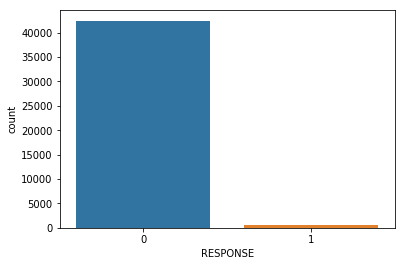

In [248]:
# Plot count of individuals whom responded to the mailout campaign
sns.countplot(mailout_train['RESPONSE'])

From above, we can say that there are only 1.24% i.e. only 532 individuals whom responded to the mailout campaign. The dataset is highly imbalanced because of the huge difference in proportion of numbers of individuals whom responded to the campaign and numbers of individuals whom did not responded.

In [249]:
# Check for missing value is 'RESPONSE' column
mailout_train['RESPONSE'].isnull().sum()

0

In [250]:
# Selecting features and response in mailout_train dataset
train_features = mailout_train.drop(['RESPONSE'], axis=1)
train_response = mailout_train['RESPONSE']

In [251]:

# Quanitfying the naturally missing data in features in descenindg order
train_features_init_null = find_missing_data(train_features)
train_features_init_null

,count,pct
ALTER_KIND4,42921,99.90
ALTER_KIND3,42788,99.59
ALTER_KIND2,42206,98.24
ALTER_KIND1,40974,95.37
KK_KUNDENTYP,25316,58.93
EXTSEL992,15948,37.12
W_KEIT_KIND_HH,9678,22.53
HH_DELTA_FLAG,9678,22.53
KBA05_ZUL1,8648,20.13
KBA05_KRSZUL,8648,20.13


In [252]:
# Identify missing or unknown data values in train_features dataframe columns and convert them to NaNs
# as per nan_vals in feat_info
for idx in feat_info.index:
    column = idx
    if column in train_features.columns:
        train_features[column] = train_features[column].replace(feat_info.loc[column]['nan_vals'], np.nan)

In [253]:

# Count value of NaN values in each column in descending order after encoding missing values
train_features_after_nan = find_missing_data(train_features)
train_features_after_nan

,count,pct
ALTER_KIND4,42921,99.90
ALTER_KIND3,42788,99.59
TITEL_KZ,42749,99.50
ALTER_KIND2,42206,98.24
ALTER_KIND1,40974,95.37
KK_KUNDENTYP,25316,58.93
KBA05_BAUMAX,22980,53.49
AGER_TYP,18890,43.97
GEBURTSJAHR,17475,40.68
EXTSEL992,15948,37.12


In [255]:
# Define function to plot histogram of missing data in columns
def plot_hist_missing_col(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing data and plot histogram of the missing data in columns
    OUTPUT:
        visualization: (histogram), of the missing data
    '''
    plt.hist(df['pct'], bins=20, facecolor='g', alpha=0.75)

    plt.xlabel('Percentage of missing value (%)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title('Histogram of missing value counts in columns', fontsize=12)
    plt.grid(True)
    plt.show()

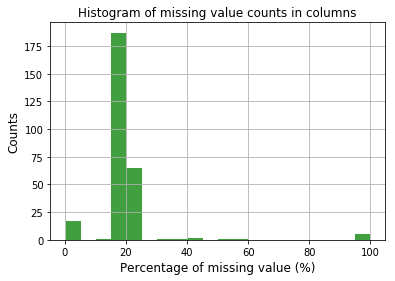

In [256]:
#Plot distribution of missing value counts in columns
plot_hist_missing_col(train_features_after_nan)

In [257]:

# Define function to plot top 50 features with missing data in a dataframe
def plot_top50_feat(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing values in its columns & plot top 50 features with misisng data
    OUTPUT:
        visualization: (bar plot), of top 50 features with missing data
    '''
    np.round((df.isnull().sum().sort_values(ascending=False)*100/df.shape[0]),2)[:50].plot.bar(figsize=(20,8),\
                                                                                               fontsize=12,color='teal');
    plt.xlabel('Column name with missing values', fontsize=18)
    plt.ylabel('Percent of missing values(%)', fontsize=18)
    plt.show()

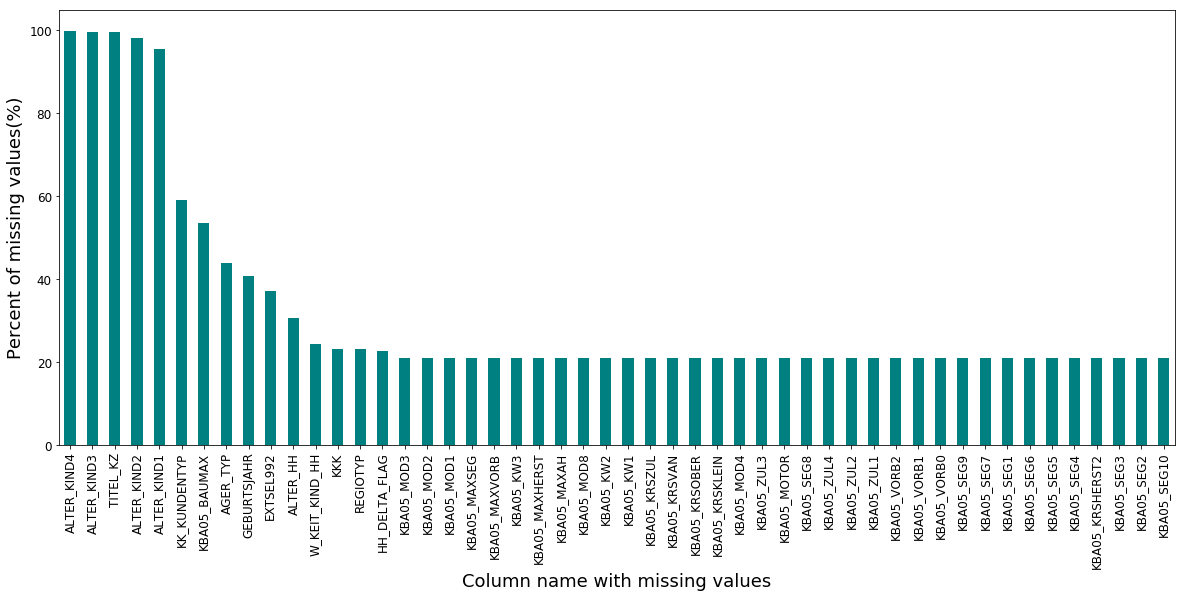

In [258]:
# Visualizing the top 50 features with missing data
plot_top50_feat(train_features)

In [261]:
# Find the name of columns with more than 25% missing values in train_features
missing_25 = cols_missing_values(train_features, p=25)
print(missing_25)

['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


In [262]:
# Number of features with more than 25% missing values
len(missing_25)

11

In [263]:
# How many features are there of each data type in train_features?
#find_feat_dtype(train_features)
print('Number of features of each data type are : {}'.format(find_feat_dtype(train_features)))

Number of features of each data type are : {dtype('int64'): 85, dtype('float64'): 275, dtype('O'): 6}


In [264]:

# Print columns with dtype as 'Object'
col_names_obj = []
for col in train_features.columns:
    if train_features[col].dtype.name == 'object':
        col_names_obj.append(col)
        
print(col_names_obj)

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']



Prepare the Data <br>
 Clean the Data <br>
Before the imbalanced dataset can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as preprocessing. Fortunately, the features are similar to the general population dataset and the customers dataset.

In order to preserve all the rows to predict, clean_data function has been revised.

In [1]:
def clean_data_revised(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned DataFrame
    """
    for idx in feat_info.index:
        column = idx
        if column in df.columns:
            df[column] = df[column].replace(feat_info.loc[column]['nan_vals'], np.nan)

    # Find the name of columns with more than 25% missing values
    missing_25 = cols_missing_values(df, p=25)
    
    # remove selected columns(columns having missing values more than 25%)
    df.drop(missing_25, axis=1, inplace=True)
    
    # drop column 'LNR' as it contains unique ID for each individual
    df.drop('LNR', axis=1, inplace=True)
    
    # select, re-encode, and engineer few features
    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(make_decade)
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(make_movement)
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    df['WOHNLAGE_rural'] = df['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
    df['WOHNLAGE_rating_class'] = df['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})
    
    df = df.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis=1)
    
    # Taking care of 6 features with dtype as 'Object'
    # 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM' & 'OST_WEST_KZ'
    df['OST_WEST_KZ'].replace(['W','O'], [1, 0], inplace=True)
    
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(make_wealth) 
    df['CAMEO_INTL_2015_life_stage'] = df['CAMEO_INTL_2015'].apply(make_life_stage)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float64')
    
    df = df.drop(['EINGEFUEGT_AM'], axis=1) # drop feature 'EINGEFUEGT_AM' as it contains unique timestamp
    
    multi = ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE']
    df = pd.get_dummies(df, columns=multi, prefix=multi, dummy_na=True, drop_first=True)

    # Return the cleaned dataframe.
    return df

In [269]:

# Prepare the data using the function clean_data_revised
train_features_cleaned = clean_data_revised(train_features)

In [270]:
train_features_cleaned.shape

(42962, 430)

Feature Transformation

In [271]:
# Impute nans with median value
imputer = Imputer(missing_values='NaN',strategy='median',axis=0)
train_features_imputed = imputer.fit_transform(train_features_cleaned)
print('Type of train_features_imputed is : {}'.format(type(train_features_imputed)))

# Making train_features_imputed into a dataframe
train_features_imputed = pd.DataFrame(train_features_imputed)
print('Type of train_features_imputed now is : {}'.format(type(train_features_imputed)))
train_features_imputed.head()

Type of train_features_imputed is : <class 'numpy.ndarray'>
Type of train_features_imputed now is : <class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,...,420,421,422,423,424,425,426,427,428,429
0,1.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,4.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,7.0,2.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [272]:
sum(train_features_imputed.isnull().sum())

0

In [273]:

# Apply feature scaling to the train_features_imputed dataset.

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_imputed)
print('Type of train_features_scaled is : {}'.format(type(train_features_scaled)))

# Making train_features_scaled into a dataframe
train_features_scaled = pd.DataFrame(train_features_scaled, columns= list(train_features_cleaned.columns.values))
print('Type of train_features_scaled now is : {}'.format(type(train_features_scaled)))
train_features_scaled.head()

Type of train_features_scaled is : <class 'numpy.ndarray'>
Type of train_features_scaled now is : <class 'pandas.core.frame.DataFrame'>


,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,D19_LETZTER_KAUF_BRANCHE_nan
0,-0.274048,-0.478176,0.659884,-0.116979,-0.204857,-0.815974,0.573741,-0.083831,-0.038459,0.303152,...,-0.094717,-0.113246,-0.112718,-0.052032,1.783482,-0.138797,-0.257011,-0.23723,-0.085392,-0.463002
1,1.594293,0.791833,-0.352970,-0.116979,-0.204857,-0.011516,-0.344470,-0.083831,-1.110675,0.303152,...,-0.094717,8.830304,-0.112718,-0.052032,-0.560701,-0.138797,-0.257011,-0.23723,-0.085392,-0.463002
2,-0.274048,-0.732178,-0.280624,-0.116979,-0.204857,-1.620432,-0.344470,-0.083831,1.033757,-1.690267,...,-0.094717,-0.113246,-0.112718,-0.052032,-0.560701,-0.138797,-0.257011,-0.23723,-0.085392,-0.463002
3,-0.274048,-0.986180,-0.135930,-0.116979,-0.204857,-0.011516,-0.114917,-0.083831,1.033757,-1.191912,...,-0.094717,-0.113246,-0.112718,-0.052032,1.783482,-0.138797,-0.257011,-0.23723,-0.085392,-0.463002
4,-0.274048,-0.224175,3.409061,-0.116979,-0.204857,-0.815974,2.945784,-0.083831,-0.038459,-0.195203,...,-0.094717,-0.113246,-0.112718,-0.052032,-0.560701,-0.138797,-0.257011,-0.23723,-0.085392,-0.463002


In [274]:
train_features_scaled.shape

(42962, 430)

 Evaluate Model Performance <br>
Since there is a large output class imbalance, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the model will be using ROC-AUC to evaluate performance.<br>

Aside from the Kaggle competition (see section below) using ROC-AUC as the score, the metric is suitable for binary classification problems such as this. ROC curves give us the ability to assess the performance of the classifier over its entire operating range. The most widely-used measure is the area under the curve (AUC). The AUC can be used to compare the performance of two or more classifiers. A single threshold can be selected and the classifiers’ performance at that point compared, or the overall performance can be compared by considering the AUC". Compared to the F1 score, the ROC does not require optimizing a threshold for each label.<br>

Classification

In [275]:
# to find the best performing classifier algorithm
def fit_classifier(clf, param_grid, X=train_features_scaled, y=train_response):
    """
    Fits a classifier to its training data using GridSearchCV and calculates ROC AUC score
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=0)
    print("Training {} :".format(clf.__class__.__name__))
    grid.fit(X, y)
    end = time.time()
    time_taken = round(end-start,2)

    print(clf.__class__.__name__)
    print("Time taken : {} secs".format(time_taken))
    print("Best score : {}".format(round(grid.best_score_,4)))
    print("*"*40)
    
    return grid.best_score_, grid.best_estimator_, time_taken

In [276]:
# Initialize classification algorithms
lor = LogisticRegression(random_state=42) # LogisticRegression
rfc = RandomForestClassifier(random_state=42) # RandomForestClassifier
abc = AdaBoostClassifier(random_state=42) # AdaBoostClassifier
gbc = GradientBoostingClassifier(random_state=42) # GradientBoostingClassifier

In [277]:
# Find best classification algorithm
clf_names = []
clf_scores = []
clf_best_ests = []
clf_time_taken = []
clf_dict = {}

for clf in [lor, rfc, abc, gbc]:
    best_score, best_est, time_taken = fit_classifier(clf, {})
    clf_names.append(clf.__class__.__name__)
    clf_scores.append(best_score)
    clf_best_ests.append(best_est)
    clf_time_taken.append(time_taken)

Training LogisticRegression :
LogisticRegression
Time taken : 145.32 secs
Best score : 0.6514
****************************************
Training RandomForestClassifier :
RandomForestClassifier
Time taken : 11.13 secs
Best score : 0.5095
****************************************
Training AdaBoostClassifier :
AdaBoostClassifier
Time taken : 106.05 secs
Best score : 0.7237
****************************************
Training GradientBoostingClassifier :
GradientBoostingClassifier
Time taken : 335.42 secs
Best score : 0.7499
****************************************


In [278]:
# Create clf_df dataframe from clf_dict
clf_dict['best_score'] = clf_scores
clf_dict['time_taken'] = clf_time_taken
clf_dict['best_est'] = clf_best_ests
clf_df = pd.DataFrame(clf_dict, index=clf_names)
clf_df

,best_score,time_taken,best_est
LogisticRegression,0.651423,145.32,"LogisticRegression(C=1.0, class_weight=None, d..."
RandomForestClassifier,0.509507,11.13,"(DecisionTreeClassifier(class_weight=None, cri..."
AdaBoostClassifier,0.723684,106.05,"(DecisionTreeClassifier(class_weight=None, cri..."
GradientBoostingClassifier,0.749907,335.42,([DecisionTreeRegressor(criterion='friedman_ms...



So, from above, we can observe that the best performing classifier algorithm among the above 4 classifiers is GradientBoostingClassifier.

In [279]:
# Print the best estimator of GradientBoostingClassifier
clf_df.loc['GradientBoostingClassifier', 'best_est']

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [280]:
# Print the classes known to the best estimator of GradientBoostingClassifier
clf_df.loc['GradientBoostingClassifier', 'best_est'].classes_


array([0, 1])

 Model Tuning

In [281]:
# Tune the best classifier(GradientBoostingClassifier) with the help of param grid in GridSearchCV
# The fine tuned model will be used with the test set
param_grid = {#'loss': ['deviance', 'exponential'],
              'loss': ['exponential'],
              #'learning_rate': [0.01, 0.1, 0.5],
              'learning_rate': [0.01],
              #'n_estimators': [50, 80, 100],
              'n_estimators': [100],
              #'max_depth': [2, 3, 4, 6, 8],
              'max_depth': [8],
              #'min_samples_split': [2,3,4]
              'min_samples_split': [2]
             }

gbc = GradientBoostingClassifier(random_state=42)
gbc_best_score, gbc_best_est, _ = fit_classifier(gbc, param_grid)
gbc_best_est

Training GradientBoostingClassifier :
GradientBoostingClassifier
Time taken : 2493.13 secs
Best score : 0.7625
****************************************


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='exponential', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [282]:
# pickle file and save the model to disk.
filename = 'best_classifier.pkl'
outfile = open(filename, 'wb')
model = gbc_best_est
pickle.dump(model, outfile)
outfile.close()

Feature Selection

In [283]:
# Print the most important features of the model
imp_feat = pd.DataFrame({'imp_feat':gbc_best_est.feature_importances_}, index=train_features_scaled.columns)
imp_feat_sorted = imp_feat.sort_values(by=['imp_feat'], ascending=False)
imp_feat_sorted.head(10)

,imp_feat
D19_SOZIALES,0.055729
KBA13_ANZAHL_PKW,0.021764
ANZ_STATISTISCHE_HAUSHALTE,0.016449
ANZ_KINDER,0.015743
KBA05_ALTER4,0.015483
UNGLEICHENN_FLAG,0.014358
D19_KONSUMTYP_MAX,0.013221
GFK_URLAUBERTYP,0.013014
KBA05_ZUL4,0.012067
D19_BANKEN_ONLINE_DATUM,0.011881


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [284]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [285]:
# Print shape of test dataset
mailout_test.shape

(42833, 366)

In [286]:
# Print first few rows of test dataset
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [287]:
# Extract feature 'LNR' to be used later for generation of the Kaggle competition CSV file with two columns
# The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition
# The second column, "RESPONSE", should be some measure of how likely each individual became a customer –
# this might not be a straightforward probability.
test_LNR = mailout_test['LNR']

# Print shape of test_LNR
test_LNR.shape

(42833,)

Prepare the test data

Clean the test data

In [288]:
# Prepare the test data using the function clean_data_revised
test_cleaned = clean_data_revised(mailout_test)

In [289]:

# Print shape of test dataset after cleaning
test_cleaned.shape

(42833, 430)

Feature Transformation of test_cleaned data

In [290]:
# Impute nans with median value in test_cleaned dataset using the imputer fitted earlier on train data
test_imputed = pd.DataFrame(imputer.transform(test_cleaned))
# Print shape of test_imputed
print('Shape of test_imputed is: {}'.format(test_imputed.shape))

# Apply feature scaling to the test_imputed dataset using the scaler fitted earlier on the train data
test_scaled = pd.DataFrame(scaler.transform(test_imputed), columns= list(test_cleaned.columns.values))
# Print shape of test_scaled
print('Shape of test_scaled is: {}'.format(test_scaled.shape))

Shape of test_imputed is: (42833, 430)
Shape of test_scaled is: (42833, 430)


Classification of test data using best model trained on train data

Predict the classes for the test data

In [291]:
# Predict the classification of the test data using best model trained earlier on train data in Part 2 
test_response = gbc_best_est.predict(test_scaled)
test_response

array([0, 0, 0, ..., 0, 0, 0])

In [292]:

# Print shape of test_response
test_response.shape

(42833,)

 Predict the class probabilities for the test data

In [293]:
# Predict the class probabilities of the test data using best model trained earlier on train data in Part 2 
test_response_proba = gbc_best_est.predict_proba(test_scaled)
test_response_proba

array([[ 0.97935517,  0.02064483],
       [ 0.98070302,  0.01929698],
       [ 0.99690537,  0.00309463],
       ..., 
       [ 0.98504708,  0.01495292],
       [ 0.97782509,  0.02217491],
       [ 0.98816393,  0.01183607]])

In [294]:
# Print shape of test_response_proba
test_response_proba.shape

(42833, 2)

In [295]:

# Print the order of the classes known to the classifier
# The array output from predict_proba has columns aligned with classes_
gbc_best_est.classes_

array([0, 1])

Output file for Kaggle competition

In [296]:
# The first column is a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition
# The second column, "RESPONSE", is a measure of how likely each individual became a customer –
# this might not be a straightforward probability.
kaggle_df = pd.DataFrame({'LNR': test_LNR, 'RESPONSE': test_response_proba[:, 1]})
kaggle_df.head()

,LNR,RESPONSE
0,1754,0.020645
1,1770,0.019297
2,1465,0.003095
3,1470,0.002879
4,1478,0.007294


In [297]:
# Generate CSV file for the Kaggle competition
kaggle_df.to_csv('kaggle_submission_file.csv', index=False)